## Imports

In [1]:
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import random
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise,BatchNormalization,Add,Layer, Lambda
from tensorflow.keras.initializers import glorot_uniform
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise,BatchNormalization,Add,Layer, Lambda
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import subprocess
import os
from sklearn.utils import column_or_1d
from sklearn.utils.multiclass import type_of_target
import gc
import torch
from numba import cuda 
from sklearn.utils import column_or_1d
from sklearn.utils.multiclass import type_of_target
import seaborn as sns
from sklearn.metrics import f1_score
import pickle
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import precision_score, recall_score, f1_score
import importlib
from matplotlib.pyplot import figure
from scipy import stats
from scipy.signal import find_peaks
import seaborn as sns
from matplotlib.patches import Patch

/opt/scp/.dev/tf/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Functions

In [2]:
def get_all_indices(mylist, myval):
    
    all_indices = []
    
    for i in range(len(mylist)):
        if mylist[i] == myval:
            all_indices.append(i)
            
    return all_indices

In [3]:
def get_mode_x_from_sns(sns_plot, plot_no):
    
    data_x, data_y = sns_plot.lines[2*plot_no].get_data()
    data_x = list(data_x)
    data_y = list(data_y)
    max_index = data_y.index(max(data_y))
    
    return data_x[max_index]

In [4]:
def moving_avg(numbers, window_size=10): 
    
    ma_list = []
    
    for j in range(len(numbers)):
        try:
            ma_list.append(np.mean(numbers[int(j-window_size/2):int(j+window_size/2)]))
        except:
            ma_list.append(numbers[j])
    
    return ma_list

In [5]:
def replacer(s, newstring, index, nofail=False):
    # raise an error if index is outside of the string
    if not nofail and index not in range(len(s)):
        raise ValueError("index outside given string")

    # if not erroring, but the index is still not in the correct range..
    if index < 0:  # add it to the beginning
        return newstring + s
    if index > len(s):  # add it to the end
        return s + newstring

    # insert the new string between "slices" of the original
    return s[index : index + len(newstring)], s[:index] + newstring + s[index + len(newstring):]

In [6]:
def get_protvec(protvec_model,schmoo_df):
    
    trigram_dict = {}
    for idx, row in protvec_model.iterrows():
        trigram_dict[row['words']] = protvec_model.iloc[idx, 1:].values.astype(float)
    trigram_list = set(trigram_dict.keys())

    target_list = list(set(schmoo_df['Modified_sequence_1']).union(schmoo_df['Modified_sequence_2']))
    target_embeddings = np.zeros((len(target_list), 100)) ## 100 is the ProtVec embedding dimensions
    length_of_target = [0 for _ in range(len(target_list))]

    for idx, gene in enumerate(target_list):
    
        target = target_list[idx]
    
        n = 3
        split_by_three = [target[i : i + n] for i in range(0, len(target), n)]
        length_of_target[idx] = len(split_by_three)

        for trigram in split_by_three: 

            if len(trigram) == 2: 
                trigram = "X" + trigram

            elif len(trigram) == 1:
                trigram = "XX" + trigram

            if trigram in trigram_list:
                target_embeddings[idx, :] = target_embeddings[idx, :] + trigram_dict[trigram]
                
    protvec_dict = dict()

    for j in tqdm(range(len(target_list))):
        protvec_dict[target_list[j]] = target_embeddings[j]
            
    protvec_vectors1 = [protvec_dict[aa] for aa in tqdm(schmoo_df['Modified_sequence_1'].tolist())]
    protvec_vectors2 = [protvec_dict[aa] for aa in tqdm(schmoo_df['Modified_sequence_2'].tolist())]
    
    schmoo_df['Protvec_1'] = protvec_vectors1
    schmoo_df['Protvec_2'] = protvec_vectors2
    
    X = [list(protvec_vectors1[i]) + list(protvec_vectors2[i]) for i in tqdm(range(len(protvec_vectors1)))]
    
    return schmoo_df, np.array(X)

In [7]:
def get_compplete_pred(schmoo_df,X,model_path='../models/',model_name='compplete_02_12_2024_fold'):

    k = 5 ##  5 folds 
    fold_pred = []
    for j in range(k):
        full_model_path = model_path + model_name + str(j) + '.h5'
        model = load_model(full_model_path)
        pred = model.predict([X[:,:100],X[:,100:]])
        fold_pred.append([x[0] for x in pred])
        
    schmoo_df['pred_fold0'] = fold_pred[0]
    schmoo_df['pred_fold1'] = fold_pred[1]
    schmoo_df['pred_fold2'] = fold_pred[2]
    schmoo_df['pred_fold3'] = fold_pred[3]
    schmoo_df['pred_fold4'] = fold_pred[4]
    
    schmoo_df['pred_fold0_delta'] = fold_pred[0] - fold_pred[0][0]
    schmoo_df['pred_fold1_delta'] = fold_pred[1] - fold_pred[1][0]
    schmoo_df['pred_fold2_delta'] = fold_pred[2] - fold_pred[2][0]
    schmoo_df['pred_fold3_delta'] = fold_pred[3] - fold_pred[3][0]
    schmoo_df['pred_fold4_delta'] = fold_pred[4] - fold_pred[4][0]
    
    schmoo_df['avg'] = schmoo_df[['pred_fold0', 'pred_fold1', 'pred_fold2', 'pred_fold3', 'pred_fold4']].mean(axis=1)
    schmoo_df['std'] = schmoo_df[['pred_fold0', 'pred_fold1', 'pred_fold2', 'pred_fold3', 'pred_fold4']].std(axis=1)
    schmoo_df['avg_delta'] = schmoo_df[['pred_fold0_delta', 'pred_fold1_delta', 'pred_fold2_delta', 'pred_fold3_delta', 'pred_fold4_delta']].mean(axis=1)
    
    return schmoo_df

In [8]:
def get_fluctuations(schmoo_df1_pred,schmoo_df2_pred):
    
    l1 = [x - schmoo_df1_pred['ComPPlete_prediction'].tolist()[0] for x in schmoo_df1_pred['ComPPlete_prediction'].tolist()[1:]]
    l2 = [x - schmoo_df2_pred['ComPPlete_prediction'].tolist()[0] for x in schmoo_df2_pred['ComPPlete_prediction'].tolist()[1:]]
    r1 = schmoo_df1_pred['Residue_locations_1'].tolist()[1:]
    r2 = schmoo_df2_pred['Residue_locations_2'].tolist()[1:]
    X = np.zeros((len(l1), len(l2)))
    for i in range(len(l1)):
        for j in range(len(l2)):
            X[i,j] = l1[i] + l2[j]
    ## TBD
    return r1, r2, X

In [9]:
def count_valley(smoothed_pred):
    
    valley_count = 0
    
    for j in range(1,len(smoothed_pred)-1):
        if (smoothed_pred[j] < smoothed_pred[j-1]) and (smoothed_pred[j] < smoothed_pred[j+1]):
            valley_count = valley_count + 1
            
    return valley_count

## Protvec Model - Adding xxx

In [10]:
protvec_model = pd.read_csv('../data/protVec_100d_3grams.csv', delimiter = '\t')

In [11]:
protvec_model_except_unk = protvec_model[0:9048]
protvec_vectors = protvec_model_except_unk.copy()
protvec_vectors_only = protvec_vectors.drop(columns=['words'])
protvec_vectors_only_matrix = np.matrix(protvec_vectors_only)

In [12]:
unknown_vector = protvec_model.loc[[9047]]
unknown_vector['words'] = 'xxx'
unknown_vector
protvec_model = pd.concat([protvec_model, unknown_vector]).reset_index(drop=True)

## Case 4.1 A-B

## Amino Acid Sequences

In [16]:
protein_4A = 'NLCPFDEVFDATRFASVYAWNRKRISNCVADYSVLYNLAPFFTFKCYGVSPTKLNDLSFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFEL'

protein_4B = 'QVQLVESGGDLVQSGGSLKLACAVSGVTLDGYSIGWFRQAPGKEREAVSYSEKSNGPTYYVASVKGRFTISRDNAKNTAYLQMNNLKPEDTGIYYCAADEAYYHERGWQSPLGWPYWGQGTQVTVSS'

In [17]:
protein_seq1 = protein_4A # Ablated
protein_seq2 = protein_4B # Fixed

t1_l = []
t2_l = []
residue_loc_1_l = []
residue_loc_2_l = []
p1_l = []
p2_l = []

for i in tqdm(range(0,len(protein_seq1)-2)):
    
    replaced_trigram1, protein_seq_replaced1 = replacer(protein_seq1, 'xxx', index=i, nofail=False)
    
    t1_l.append(replaced_trigram1)
    residue_loc_1_l.append(protein_seq1[i] + '-' + str(i) + '-' + protein_seq1[i+1] + '-' + str(i+1) + '-' + protein_seq1[i+2] + '-' + str(i+2))
    p1_l.append(protein_seq_replaced1)
    t2_l.append('None')
    residue_loc_2_l.append('None')
    p2_l.append(protein_seq2)

schmoo_df1 = pd.DataFrame()
schmoo_df1['Trigram_replaced_1'] = ['None'] + t1_l
schmoo_df1['Residue_locations_1'] = ['None'] + residue_loc_1_l
schmoo_df1['Modified_sequence_1'] = [protein_seq1] + p1_l
schmoo_df1['Trigram_replaced_2'] = ['None'] + t2_l
schmoo_df1['Residue_locations_2'] = ['None'] + residue_loc_2_l
schmoo_df1['Modified_sequence_2'] = [protein_seq2] + p2_l

100%|██████████| 182/182 [00:00<00:00, 391468.37it/s]


In [18]:
schmoo_df1_protvec, X = get_protvec(protvec_model,schmoo_df1)

100%|██████████| 183/183 [00:00<00:00, 110726.72it/s]


In [19]:
schmoo_df1_pred = get_compplete_pred(schmoo_df1,X)

6/6 [==============================] - 0s 2ms/step


In [20]:
l = schmoo_df1_pred['avg'].tolist()
print(min(l),max(l))

0.42632022500038147 0.6197075247764587


/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


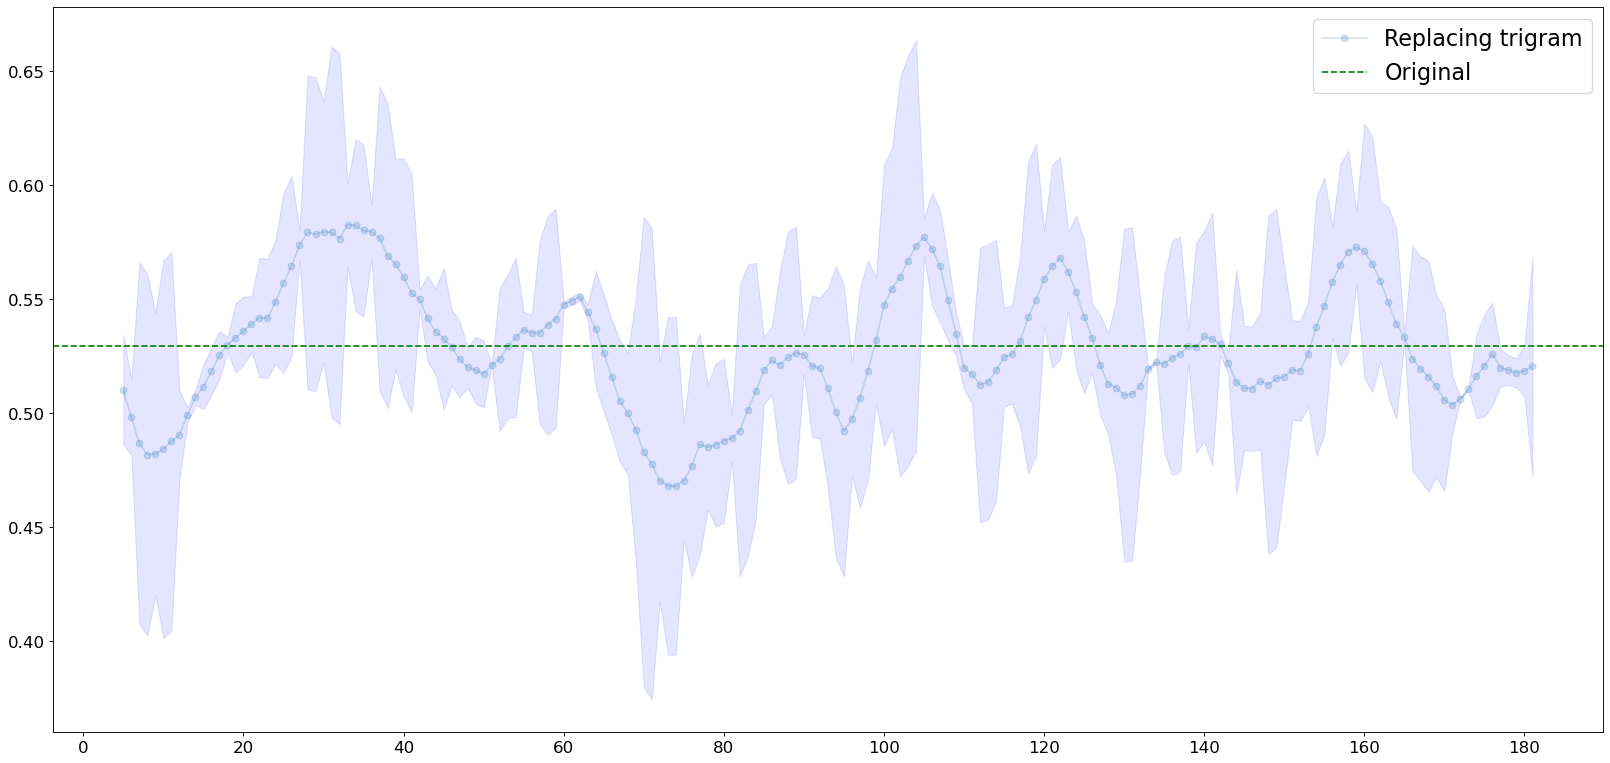

In [21]:
figure(figsize=(25, 12), dpi=80)
x = range(len(schmoo_df1_pred['Trigram_replaced_1'].tolist())-1)
window_size = 10
y = moving_avg(schmoo_df1_pred['avg'].tolist()[1:], window_size=window_size)
y_err = schmoo_df1_pred['avg_delta'].tolist()[1:]
ymax = [(y[j]+np.abs(y_err[j])) for j in x]
ymin = [(y[j]-np.abs(y_err[j])) for j in x]
plt.plot(x,y, '-o', alpha=0.2, label='Replacing trigram')
plt.fill_between(x, ymax, ymin, color='blue', alpha=0.1)
plt.axhline(y=schmoo_df1_pred['avg'].tolist()[0], color='g', linestyle='--', label='Original')
plt.xticks(np.arange(min(x), max(x)+1, 20),rotation = 0,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Case 4.1 B-A

## Amino Acid Sequences

In [22]:
protein_4A = 'NLCPFDEVFDATRFASVYAWNRKRISNCVADYSVLYNLAPFFTFKCYGVSPTKLNDLSFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFEL'

protein_4B = 'QVQLVESGGDLVQSGGSLKLACAVSGVTLDGYSIGWFRQAPGKEREAVSYSEKSNGPTYYVASVKGRFTISRDNAKNTAYLQMNNLKPEDTGIYYCAADEAYYHERGWQSPLGWPYWGQGTQVTVSS'

In [23]:
protein_seq1 = protein_4B # Ablated
protein_seq2 = protein_4A # Fixed

t1_l = []
t2_l = []
residue_loc_1_l = []
residue_loc_2_l = []
p1_l = []
p2_l = []

for i in tqdm(range(0,len(protein_seq1)-2)):
    
    replaced_trigram1, protein_seq_replaced1 = replacer(protein_seq1, 'xxx', index=i, nofail=False)
    
    t1_l.append(replaced_trigram1)
    residue_loc_1_l.append(protein_seq1[i] + '-' + str(i) + '-' + protein_seq1[i+1] + '-' + str(i+1) + '-' + protein_seq1[i+2] + '-' + str(i+2))
    p1_l.append(protein_seq_replaced1)
    t2_l.append('None')
    residue_loc_2_l.append('None')
    p2_l.append(protein_seq2)

schmoo_df1 = pd.DataFrame()
schmoo_df1['Trigram_replaced_1'] = ['None'] + t1_l
schmoo_df1['Residue_locations_1'] = ['None'] + residue_loc_1_l
schmoo_df1['Modified_sequence_1'] = [protein_seq1] + p1_l
schmoo_df1['Trigram_replaced_2'] = ['None'] + t2_l
schmoo_df1['Residue_locations_2'] = ['None'] + residue_loc_2_l
schmoo_df1['Modified_sequence_2'] = [protein_seq2] + p2_l

100%|██████████| 125/125 [00:00<00:00, 388937.69it/s]


In [24]:
schmoo_df1_protvec, X = get_protvec(protvec_model,schmoo_df1)

100%|██████████| 126/126 [00:00<00:00, 107655.80it/s]


In [25]:
schmoo_df1_pred = get_compplete_pred(schmoo_df1,X)

4/4 [==============================] - 0s 2ms/step


In [26]:
l = schmoo_df1_pred['avg'].tolist()
print(min(l),max(l))

0.2975715696811676 0.5415074825286865


/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


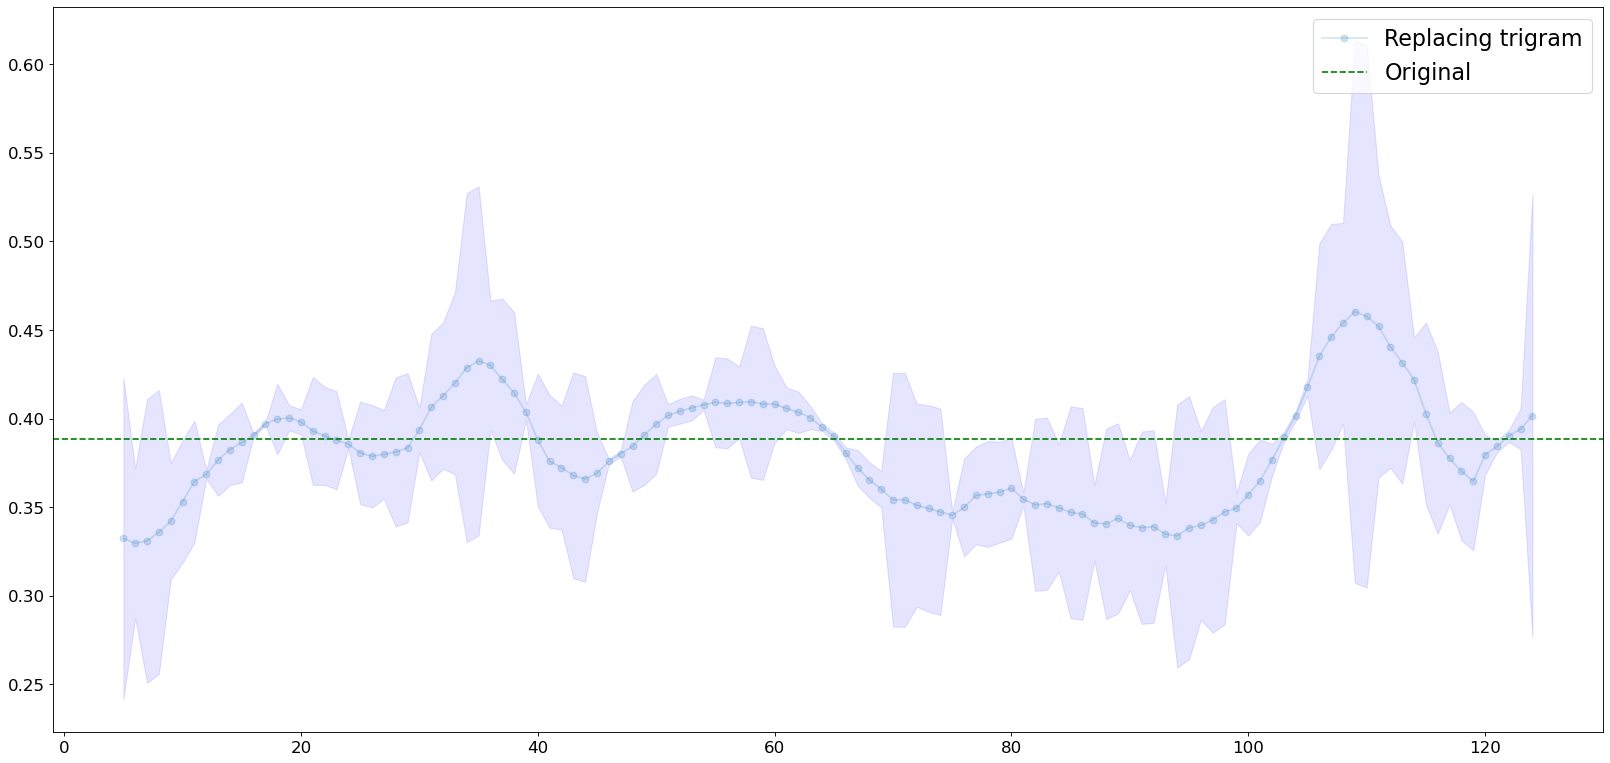

In [27]:
figure(figsize=(25, 12), dpi=80)
x = range(len(schmoo_df1_pred['Trigram_replaced_1'].tolist())-1)
window_size = 10
y = moving_avg(schmoo_df1_pred['avg'].tolist()[1:], window_size=window_size)
y_err = schmoo_df1_pred['avg_delta'].tolist()[1:]
ymax = [(y[j]+np.abs(y_err[j])) for j in x]
ymin = [(y[j]-np.abs(y_err[j])) for j in x]
plt.plot(x,y, '-o', alpha=0.2, label='Replacing trigram')
plt.fill_between(x, ymax, ymin, color='blue', alpha=0.1)
plt.axhline(y=schmoo_df1_pred['avg'].tolist()[0], color='g', linestyle='--', label='Original')
plt.xticks(np.arange(min(x), max(x)+1, 20),rotation = 0,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Case 4.1 A-C

## Amino Acid Sequences

In [28]:
protein_4A = 'NLCPFDEVFDATRFASVYAWNRKRISNCVADYSVLYNLAPFFTFKCYGVSPTKLNDLSFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFEL'

protein_4C = 'QVQLVESGGGLVRTGGSLRLSCAASGSILQIWAMKWYRQAPGLQREWIATIPNSGEPFYASSVEGRFTGSRENEETVYLYLNNLEPEDTAVYYCEVNEGVPVREYWGQGTQVTVSS'

In [29]:
protein_seq1 = protein_4A # Ablated
protein_seq2 = protein_4C # Fixed

t1_l = []
t2_l = []
residue_loc_1_l = []
residue_loc_2_l = []
p1_l = []
p2_l = []

for i in tqdm(range(0,len(protein_seq1)-2)):
    
    replaced_trigram1, protein_seq_replaced1 = replacer(protein_seq1, 'xxx', index=i, nofail=False)
    
    t1_l.append(replaced_trigram1)
    residue_loc_1_l.append(protein_seq1[i] + '-' + str(i) + '-' + protein_seq1[i+1] + '-' + str(i+1) + '-' + protein_seq1[i+2] + '-' + str(i+2))
    p1_l.append(protein_seq_replaced1)
    t2_l.append('None')
    residue_loc_2_l.append('None')
    p2_l.append(protein_seq2)

schmoo_df1 = pd.DataFrame()
schmoo_df1['Trigram_replaced_1'] = ['None'] + t1_l
schmoo_df1['Residue_locations_1'] = ['None'] + residue_loc_1_l
schmoo_df1['Modified_sequence_1'] = [protein_seq1] + p1_l
schmoo_df1['Trigram_replaced_2'] = ['None'] + t2_l
schmoo_df1['Residue_locations_2'] = ['None'] + residue_loc_2_l
schmoo_df1['Modified_sequence_2'] = [protein_seq2] + p2_l

100%|██████████| 182/182 [00:00<00:00, 410189.86it/s]


In [30]:
schmoo_df1_protvec, X = get_protvec(protvec_model,schmoo_df1)

100%|██████████| 183/183 [00:00<00:00, 109823.67it/s]


In [31]:
schmoo_df1_pred = get_compplete_pred(schmoo_df1,X)

6/6 [==============================] - 0s 2ms/step


In [32]:
l = schmoo_df1_pred['avg'].tolist()
print(min(l),max(l))

0.709030270576477 0.8411527872085571


/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


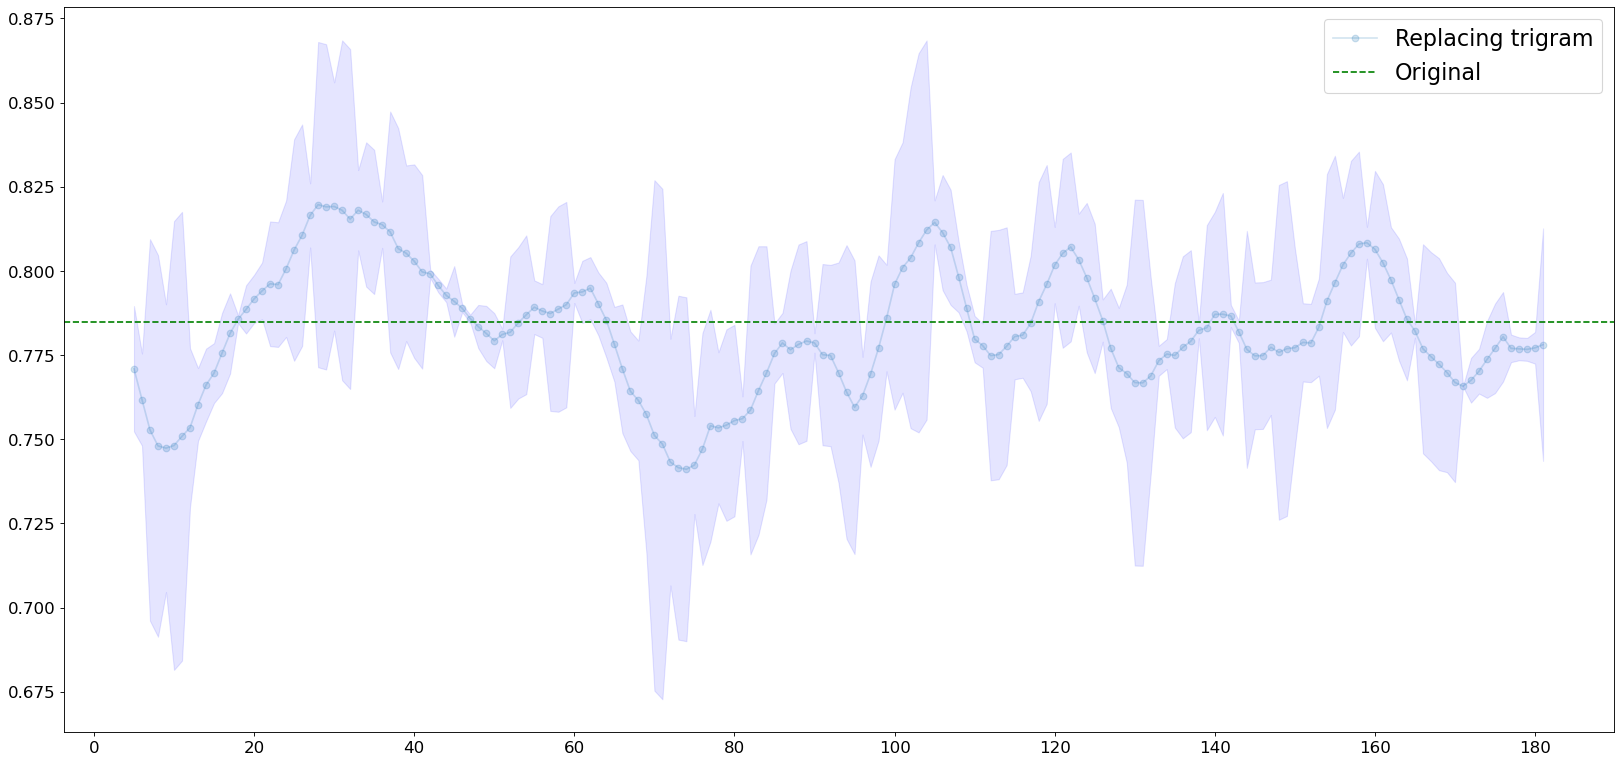

In [33]:
figure(figsize=(25, 12), dpi=80)
x = range(len(schmoo_df1_pred['Trigram_replaced_1'].tolist())-1)
window_size = 10
y = moving_avg(schmoo_df1_pred['avg'].tolist()[1:], window_size=window_size)
y_err = schmoo_df1_pred['avg_delta'].tolist()[1:]
ymax = [(y[j]+np.abs(y_err[j])) for j in x]
ymin = [(y[j]-np.abs(y_err[j])) for j in x]
plt.plot(x,y, '-o', alpha=0.2, label='Replacing trigram')
plt.fill_between(x, ymax, ymin, color='blue', alpha=0.1)
plt.axhline(y=schmoo_df1_pred['avg'].tolist()[0], color='g', linestyle='--', label='Original')
plt.xticks(np.arange(min(x), max(x)+1, 20),rotation = 0,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Case 4.1 C-A

## Amino Acid Sequences

In [34]:
protein_4A = 'NLCPFDEVFDATRFASVYAWNRKRISNCVADYSVLYNLAPFFTFKCYGVSPTKLNDLSFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFEL'

protein_4C = 'QVQLVESGGGLVRTGGSLRLSCAASGSILQIWAMKWYRQAPGLQREWIATIPNSGEPFYASSVEGRFTGSRENEETVYLYLNNLEPEDTAVYYCEVNEGVPVREYWGQGTQVTVSS'

In [35]:
protein_seq1 = protein_4C # Ablated
protein_seq2 = protein_4A # Fixed

t1_l = []
t2_l = []
residue_loc_1_l = []
residue_loc_2_l = []
p1_l = []
p2_l = []

for i in tqdm(range(0,len(protein_seq1)-2)):
    
    replaced_trigram1, protein_seq_replaced1 = replacer(protein_seq1, 'xxx', index=i, nofail=False)
    
    t1_l.append(replaced_trigram1)
    residue_loc_1_l.append(protein_seq1[i] + '-' + str(i) + '-' + protein_seq1[i+1] + '-' + str(i+1) + '-' + protein_seq1[i+2] + '-' + str(i+2))
    p1_l.append(protein_seq_replaced1)
    t2_l.append('None')
    residue_loc_2_l.append('None')
    p2_l.append(protein_seq2)

schmoo_df1 = pd.DataFrame()
schmoo_df1['Trigram_replaced_1'] = ['None'] + t1_l
schmoo_df1['Residue_locations_1'] = ['None'] + residue_loc_1_l
schmoo_df1['Modified_sequence_1'] = [protein_seq1] + p1_l
schmoo_df1['Trigram_replaced_2'] = ['None'] + t2_l
schmoo_df1['Residue_locations_2'] = ['None'] + residue_loc_2_l
schmoo_df1['Modified_sequence_2'] = [protein_seq2] + p2_l

100%|██████████| 114/114 [00:00<00:00, 369228.31it/s]


In [36]:
schmoo_df1_protvec, X = get_protvec(protvec_model,schmoo_df1)

100%|██████████| 115/115 [00:00<00:00, 108294.78it/s]


In [37]:
schmoo_df1_pred = get_compplete_pred(schmoo_df1,X)

4/4 [==============================] - 0s 2ms/step


In [38]:
l = schmoo_df1_pred['avg'].tolist()
print(min(l),max(l))

0.6499690413475037 0.8050419688224792


/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


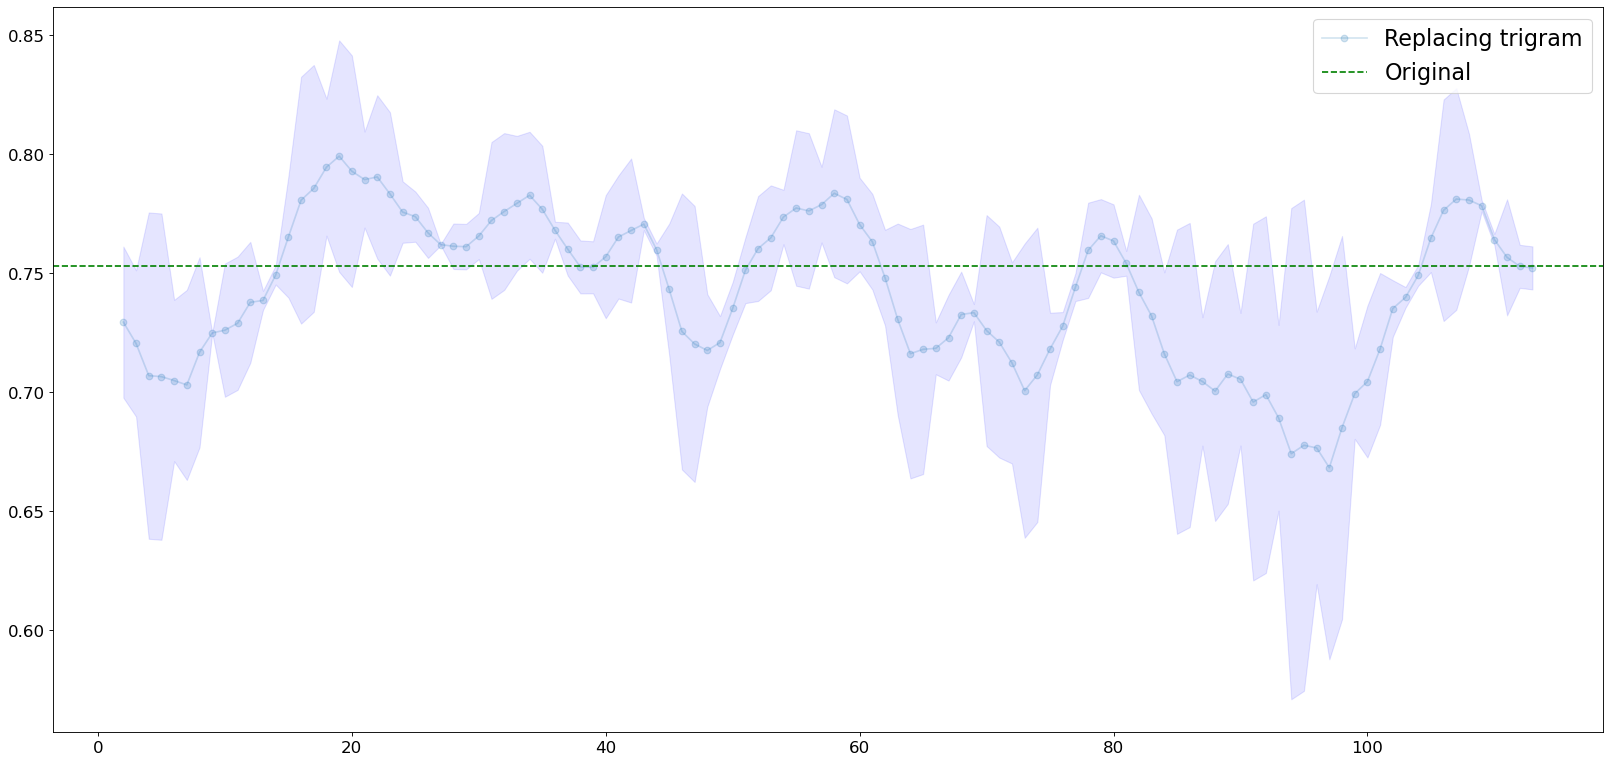

In [39]:
figure(figsize=(25, 12), dpi=80)
x = range(len(schmoo_df1_pred['Trigram_replaced_1'].tolist())-1)
window_size = 5
y = moving_avg(schmoo_df1_pred['avg'].tolist()[1:], window_size=window_size)
y_err = schmoo_df1_pred['avg_delta'].tolist()[1:]
ymax = [(y[j]+np.abs(y_err[j])) for j in x]
ymin = [(y[j]-np.abs(y_err[j])) for j in x]
plt.plot(x,y, '-o', alpha=0.2, label='Replacing trigram')
plt.fill_between(x, ymax, ymin, color='blue', alpha=0.1)
plt.axhline(y=schmoo_df1_pred['avg'].tolist()[0], color='g', linestyle='--', label='Original')
plt.xticks(np.arange(min(x), max(x)+1, 20),rotation = 0,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Case 5 A-B

## Amino Acid Sequences

In [40]:
protein_5A = 'VTAITIMALYSIVCVVGLFGNFLVMYVIVRYTKMKTATNIYIFNLALADALATSTLPFQSVNYLMGTWPFGNILCKIVISIDYYNMFTSIFTLCTMSVDRYIAVCHPVKALDFRTPRNAKIVNVCNWILSSAIGLPVMFMATTKYRQGSIDCTLTFSHPTWYWENLLKICVFIFAFIMPVLIITVCYGLMILRLKSVRMLSGSKEKDRNLRRITRMVLVVVAVFIVCWTPIHIYVIIKALITIPETTFQTVSWHFCIALGYTNSCLNPVLYAFLDENFKRCFREFCI'

protein_5B = 'AQVQLVESGGGLVQAGGSLRLSCAASGSISSISTMGWYRQAPGKERELVAAITSGGSTNYADSVKGRFTISRDNAKNTVYLQMNSLKPEDTAVYYCNFKYYSGSYFYKSEYDYWGKGTPVTVSSA'

In [41]:
protein_seq1 = protein_5A # Ablated
protein_seq2 = protein_5B # Fixed

t1_l = []
t2_l = []
residue_loc_1_l = []
residue_loc_2_l = []
p1_l = []
p2_l = []

for i in tqdm(range(0,len(protein_seq1)-2)):
    
    replaced_trigram1, protein_seq_replaced1 = replacer(protein_seq1, 'xxx', index=i, nofail=False)
    
    t1_l.append(replaced_trigram1)
    residue_loc_1_l.append(protein_seq1[i] + '-' + str(i) + '-' + protein_seq1[i+1] + '-' + str(i+1) + '-' + protein_seq1[i+2] + '-' + str(i+2))
    p1_l.append(protein_seq_replaced1)
    t2_l.append('None')
    residue_loc_2_l.append('None')
    p2_l.append(protein_seq2)

schmoo_df1 = pd.DataFrame()
schmoo_df1['Trigram_replaced_1'] = ['None'] + t1_l
schmoo_df1['Residue_locations_1'] = ['None'] + residue_loc_1_l
schmoo_df1['Modified_sequence_1'] = [protein_seq1] + p1_l
schmoo_df1['Trigram_replaced_2'] = ['None'] + t2_l
schmoo_df1['Residue_locations_2'] = ['None'] + residue_loc_2_l
schmoo_df1['Modified_sequence_2'] = [protein_seq2] + p2_l

100%|██████████| 285/285 [00:00<00:00, 381665.59it/s]


In [42]:
schmoo_df1_protvec, X = get_protvec(protvec_model,schmoo_df1)

100%|██████████| 286/286 [00:00<00:00, 97091.94it/s]


In [43]:
schmoo_df1_pred = get_compplete_pred(schmoo_df1,X)

9/9 [==============================] - 0s 2ms/step


In [44]:
l = schmoo_df1_pred['avg'].tolist()
print(min(l),max(l))

0.12330392748117447 0.22046664357185364


/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


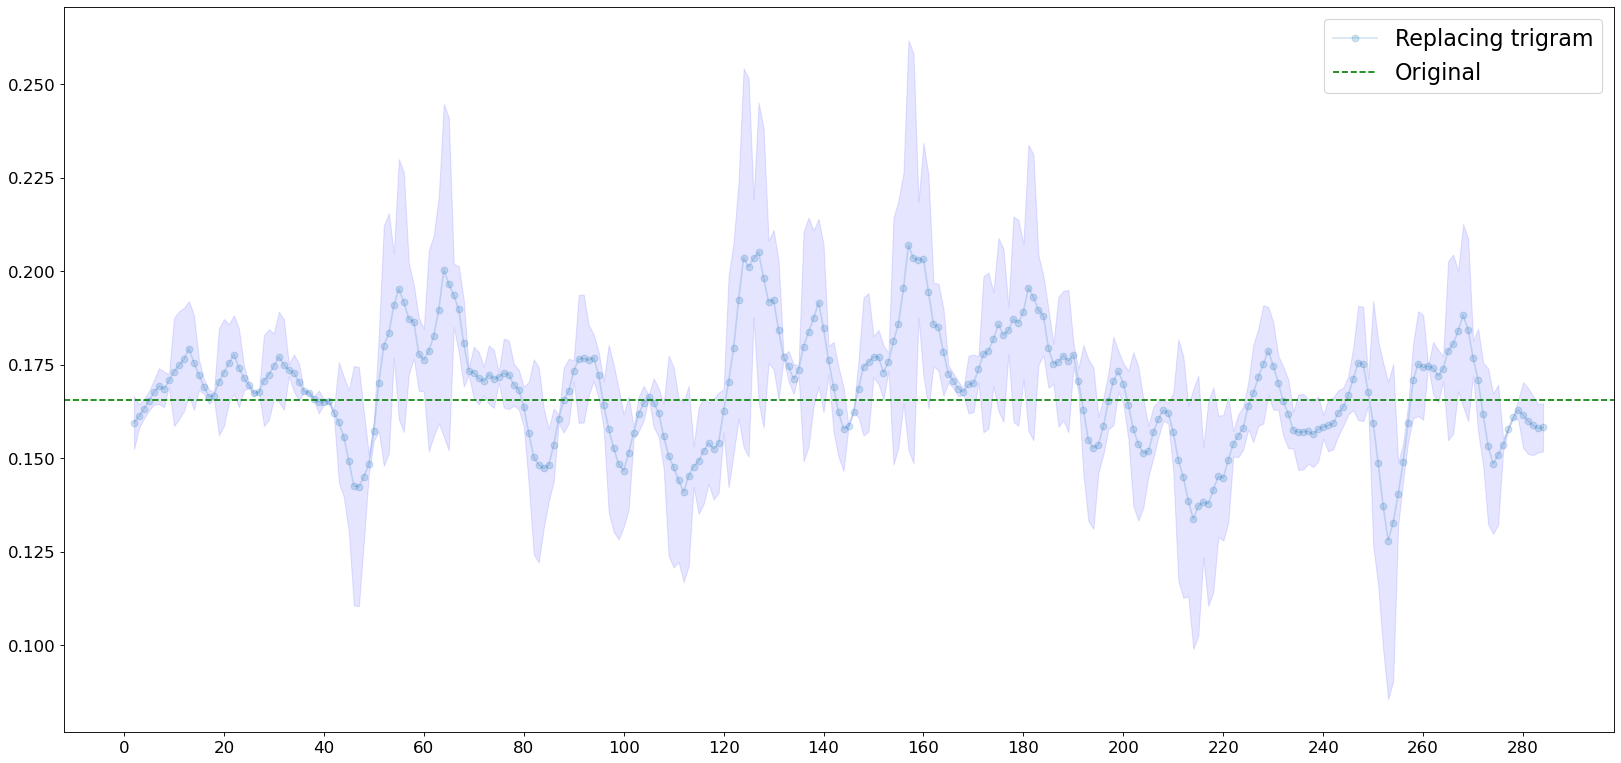

In [45]:
figure(figsize=(25, 12), dpi=80)
x = range(len(schmoo_df1_pred['Trigram_replaced_1'].tolist())-1)
window_size = 5
y = moving_avg(schmoo_df1_pred['avg'].tolist()[1:], window_size=window_size)
y_err = schmoo_df1_pred['avg_delta'].tolist()[1:]
ymax = [(y[j]+np.abs(y_err[j])) for j in x]
ymin = [(y[j]-np.abs(y_err[j])) for j in x]
plt.plot(x,y, '-o', alpha=0.2, label='Replacing trigram')
plt.fill_between(x, ymax, ymin, color='blue', alpha=0.1)
plt.axhline(y=schmoo_df1_pred['avg'].tolist()[0], color='g', linestyle='--', label='Original')
plt.xticks(np.arange(min(x), max(x)+1, 20),rotation = 0,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Case 5 B-A

## Amino Acid Sequences

In [46]:
protein_5A = 'VTAITIMALYSIVCVVGLFGNFLVMYVIVRYTKMKTATNIYIFNLALADALATSTLPFQSVNYLMGTWPFGNILCKIVISIDYYNMFTSIFTLCTMSVDRYIAVCHPVKALDFRTPRNAKIVNVCNWILSSAIGLPVMFMATTKYRQGSIDCTLTFSHPTWYWENLLKICVFIFAFIMPVLIITVCYGLMILRLKSVRMLSGSKEKDRNLRRITRMVLVVVAVFIVCWTPIHIYVIIKALITIPETTFQTVSWHFCIALGYTNSCLNPVLYAFLDENFKRCFREFCI'

protein_5B = 'AQVQLVESGGGLVQAGGSLRLSCAASGSISSISTMGWYRQAPGKERELVAAITSGGSTNYADSVKGRFTISRDNAKNTVYLQMNSLKPEDTAVYYCNFKYYSGSYFYKSEYDYWGKGTPVTVSSA'

In [47]:
protein_seq1 = protein_5B # Ablated
protein_seq2 = protein_5A # Fixed

t1_l = []
t2_l = []
residue_loc_1_l = []
residue_loc_2_l = []
p1_l = []
p2_l = []

for i in tqdm(range(0,len(protein_seq1)-2)):
    
    replaced_trigram1, protein_seq_replaced1 = replacer(protein_seq1, 'xxx', index=i, nofail=False)
    
    t1_l.append(replaced_trigram1)
    residue_loc_1_l.append(protein_seq1[i] + '-' + str(i) + '-' + protein_seq1[i+1] + '-' + str(i+1) + '-' + protein_seq1[i+2] + '-' + str(i+2))
    p1_l.append(protein_seq_replaced1)
    t2_l.append('None')
    residue_loc_2_l.append('None')
    p2_l.append(protein_seq2)

schmoo_df1 = pd.DataFrame()
schmoo_df1['Trigram_replaced_1'] = ['None'] + t1_l
schmoo_df1['Residue_locations_1'] = ['None'] + residue_loc_1_l
schmoo_df1['Modified_sequence_1'] = [protein_seq1] + p1_l
schmoo_df1['Trigram_replaced_2'] = ['None'] + t2_l
schmoo_df1['Residue_locations_2'] = ['None'] + residue_loc_2_l
schmoo_df1['Modified_sequence_2'] = [protein_seq2] + p2_l

100%|██████████| 123/123 [00:00<00:00, 355058.08it/s]


In [48]:
schmoo_df1_protvec, X = get_protvec(protvec_model,schmoo_df1)

100%|██████████| 124/124 [00:00<00:00, 108262.63it/s]


In [49]:
schmoo_df1_pred = get_compplete_pred(schmoo_df1,X)

4/4 [==============================] - 0s 2ms/step


In [50]:
l = schmoo_df1_pred['avg'].tolist()
print(min(l),max(l))

0.3956591784954071 0.48658308386802673


/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


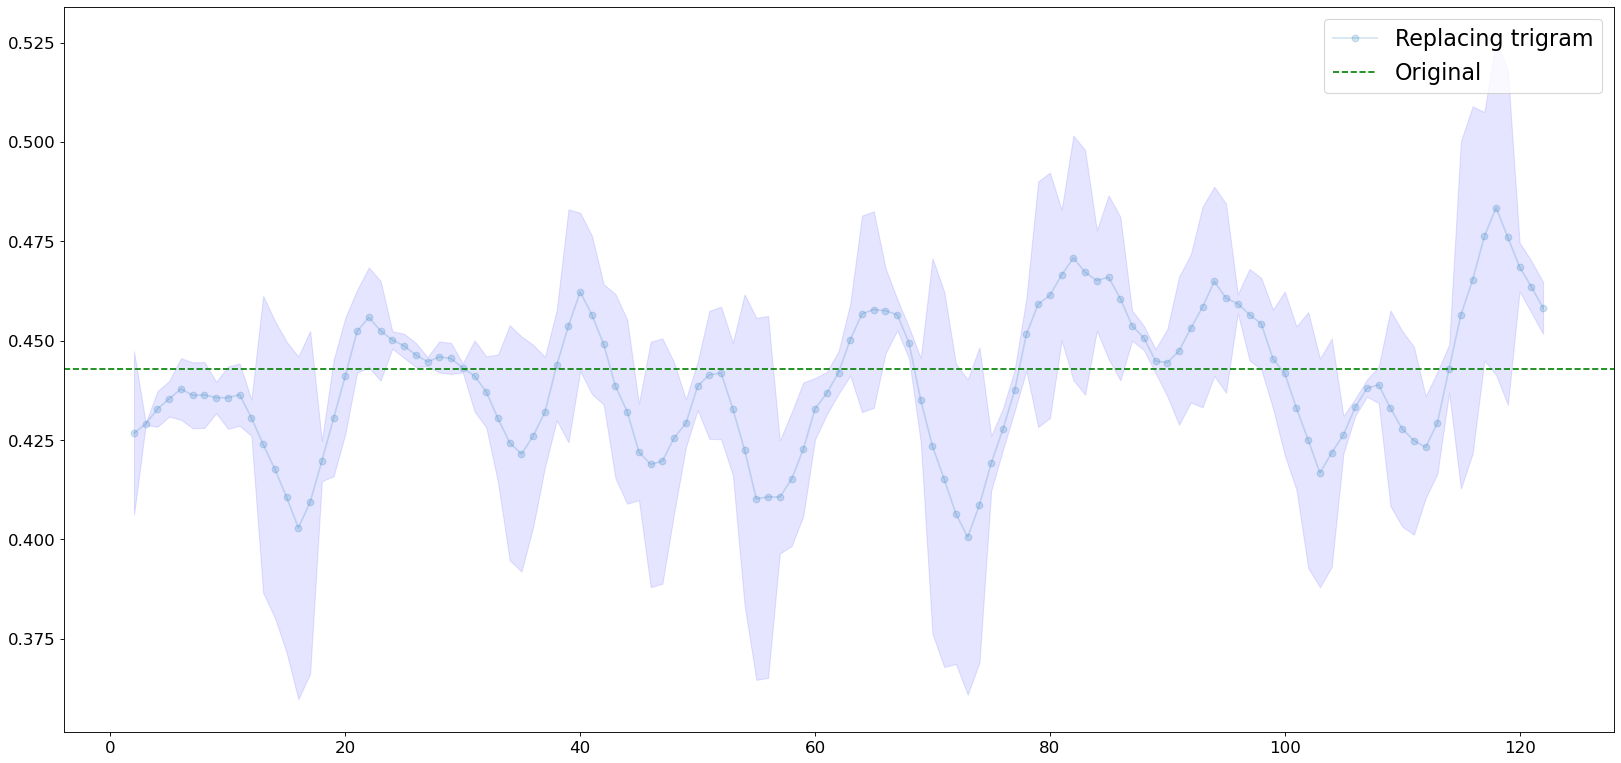

In [51]:
figure(figsize=(25, 12), dpi=80)
x = range(len(schmoo_df1_pred['Trigram_replaced_1'].tolist())-1)
window_size = 5
y = moving_avg(schmoo_df1_pred['avg'].tolist()[1:], window_size=window_size)
y_err = schmoo_df1_pred['avg_delta'].tolist()[1:]
ymax = [(y[j]+np.abs(y_err[j])) for j in x]
ymin = [(y[j]-np.abs(y_err[j])) for j in x]
plt.plot(x,y, '-o', alpha=0.2, label='Replacing trigram')
plt.fill_between(x, ymax, ymin, color='blue', alpha=0.1)
plt.axhline(y=schmoo_df1_pred['avg'].tolist()[0], color='g', linestyle='--', label='Original')
plt.xticks(np.arange(min(x), max(x)+1, 20),rotation = 0,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Case 6 A-B

## Amino Acid Sequences

In [52]:
protein_6A = 'MLTLQTWLVQALFIFLTTESTGELLDPCGYISPESPVVQLHSNFTAVCVLKEKCMDYFHVNANYIVWKTNHFTIPKEQYTIINRTASSVTFTDIASLNIQLTCNILTFGQLEQNVYGITIISGLPPEKPKNLSCIVNEGKKMRCEWDGGRETHLETNFTLKSEWATHKFADCKAKRDTPTSCTVDYSTVYFVNIEVWVEAENALGKVTSDHINFDPVYKVKPNPPHNLSVINSEELSSILKLTWTNPSIKSVIILKYNIQYRTKDASTWSQIPPEDTASTRSSFTVQDLKPFTEYVFRIRCMKEDGKGYWSDWSEEASGITYEDRPSKAPSFWYKIDPSHTQGYRTVQLVWKTLPPFEANGKILDYEVTLTRWKSHLQNYTVNATKLTVNLTNDRYLATLTVRNLVGKSDAAVLTIPACDFQATHPVMDLKAFPKDNMLWVEWTTPRESVKKYILEWCVLSDKAPCITDWQQEDGTVHRTYLRGNLAESKCYLITVTPVYADGPGSPESIKAYLKQAPPSKGPTVRTKKVGKNEAVLEWDQLPVDVQNGFIRNYTIFYRTIIGNETAVNVDSSHTEYTLSSLTSDTLYMVRMAAYTDEGGKDGPEFTFTTPKFAQGEIEAIVVPVCLAFLLTTLLGVLFCFNKRDLIKKHIWPNVPDPSKSHIAQWSPHTPPRHNFNSKDQMYSDGNFTDVSVVEIEANDKKPFPEDLKSLDLFKKEKINTEGHSSGIGGSSCMSSSRPSISSSDENESSQNTSSTVQYSTVVHSGYRHQVPSVQVFSRSESTQPLLDSEERPEDLQLVDHVDGGDGILPRQQYFKQNCSQHESSPDISHFERSKQVSSVNEEDFVRLKQQISDHISQSCGSGQMKMFQEVSAADAFGPGTEGQVERFETVGMEAATDEGMPKSYLPQTVRQGGYMPQ'

protein_6B = 'CAIRHPCHNNLMNQIRSQLAQLNGSANALFILYYTAQGEPFPNNLDKLCGPNVTDFPPFHANGTEKAKLVELYRIVVYLGTSLGNITRDQKILNPSALSLHSKLNATADILRGLLSNVLCRLCSKYHVGHVDVTYGPDTSGKDVFQKKKLGCQLLGKYKQIIAVLAQAF'

In [53]:
protein_seq1 = protein_6A # Ablated
protein_seq2 = protein_6B # Fixed

t1_l = []
t2_l = []
residue_loc_1_l = []
residue_loc_2_l = []
p1_l = []
p2_l = []

for i in tqdm(range(0,len(protein_seq1)-2)):
    
    replaced_trigram1, protein_seq_replaced1 = replacer(protein_seq1, 'xxx', index=i, nofail=False)
    
    t1_l.append(replaced_trigram1)
    residue_loc_1_l.append(protein_seq1[i] + '-' + str(i) + '-' + protein_seq1[i+1] + '-' + str(i+1) + '-' + protein_seq1[i+2] + '-' + str(i+2))
    p1_l.append(protein_seq_replaced1)
    t2_l.append('None')
    residue_loc_2_l.append('None')
    p2_l.append(protein_seq2)

schmoo_df1 = pd.DataFrame()
schmoo_df1['Trigram_replaced_1'] = ['None'] + t1_l
schmoo_df1['Residue_locations_1'] = ['None'] + residue_loc_1_l
schmoo_df1['Modified_sequence_1'] = [protein_seq1] + p1_l
schmoo_df1['Trigram_replaced_2'] = ['None'] + t2_l
schmoo_df1['Residue_locations_2'] = ['None'] + residue_loc_2_l
schmoo_df1['Modified_sequence_2'] = [protein_seq2] + p2_l

100%|██████████| 916/916 [00:00<00:00, 418061.20it/s]


In [54]:
schmoo_df1_protvec, X = get_protvec(protvec_model,schmoo_df1)

100%|██████████| 917/917 [00:00<00:00, 106016.61it/s]


In [55]:
schmoo_df1_pred = get_compplete_pred(schmoo_df1,X)

29/29 [==============================] - 0s 2ms/step


In [56]:
l = schmoo_df1_pred['avg'].tolist()
print(min(l),max(l))

0.39653706550598145 0.5121511816978455


/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


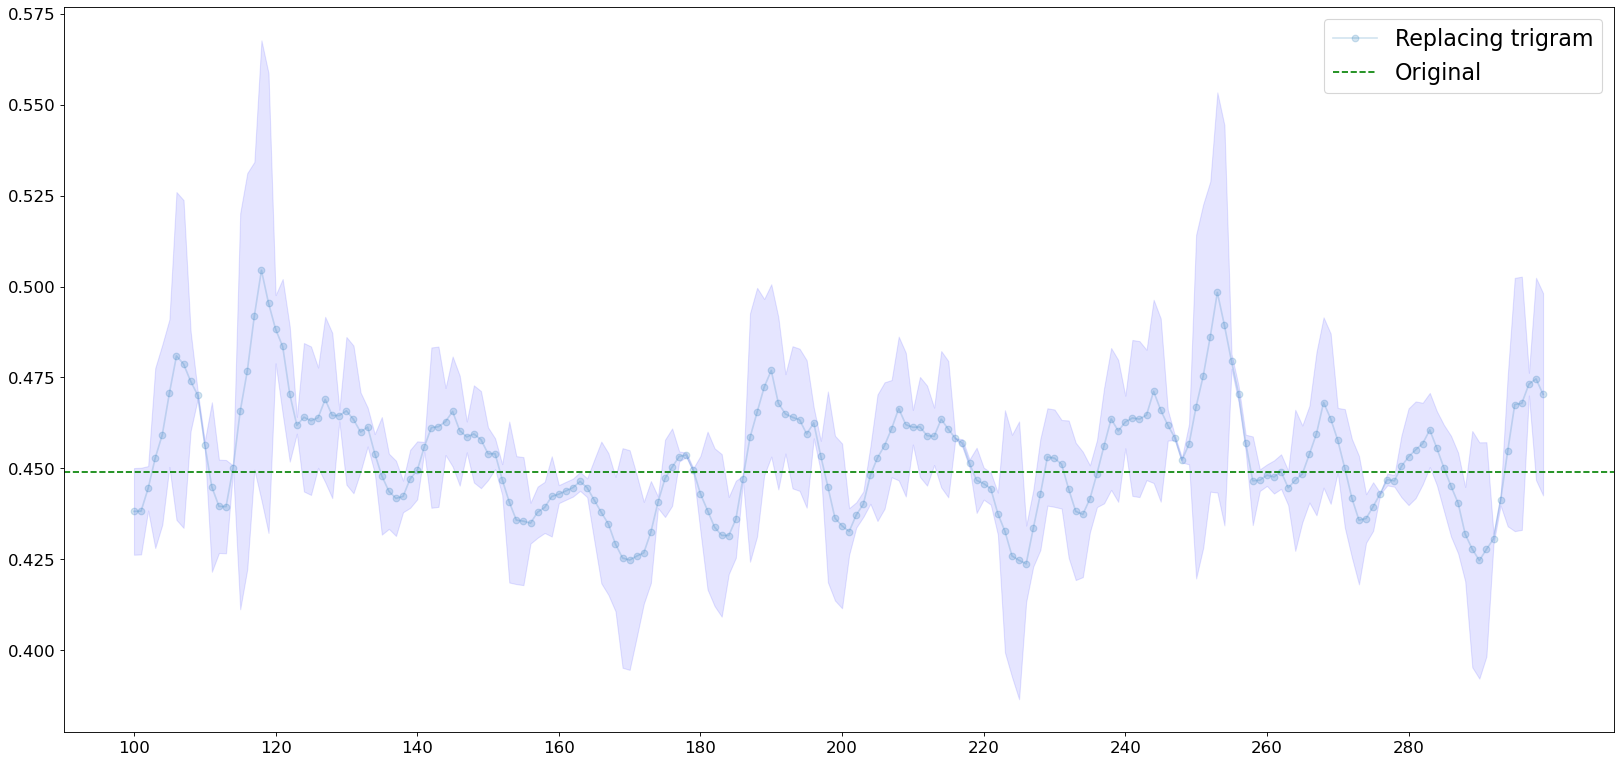

In [57]:
figure(figsize=(25, 12), dpi=80)
x_index = range(200)#range(len(schmoo_df1_pred['Trigram_replaced_1'].tolist())-1)
x = [j+100 for j in x_index]
window_size = 5
y = moving_avg(schmoo_df1_pred['avg'].tolist()[1:], window_size=window_size)[100:300]
y_err = schmoo_df1_pred['avg_delta'].tolist()[1:][100:300]
ymax = [(y[j]+np.abs(y_err[j])) for j in x_index]
ymin = [(y[j]-np.abs(y_err[j])) for j in x_index]
plt.plot(x,y, '-o', alpha=0.2, label='Replacing trigram')
plt.fill_between(x, ymax, ymin, color='blue', alpha=0.1)
plt.axhline(y=schmoo_df1_pred['avg'].tolist()[0], color='g', linestyle='--', label='Original')
plt.xticks(np.arange(min(x), max(x)+1, 20),rotation = 0,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Case 6 B-A

## Amino Acid Sequences

In [58]:
protein_6A = 'MLTLQTWLVQALFIFLTTESTGELLDPCGYISPESPVVQLHSNFTAVCVLKEKCMDYFHVNANYIVWKTNHFTIPKEQYTIINRTASSVTFTDIASLNIQLTCNILTFGQLEQNVYGITIISGLPPEKPKNLSCIVNEGKKMRCEWDGGRETHLETNFTLKSEWATHKFADCKAKRDTPTSCTVDYSTVYFVNIEVWVEAENALGKVTSDHINFDPVYKVKPNPPHNLSVINSEELSSILKLTWTNPSIKSVIILKYNIQYRTKDASTWSQIPPEDTASTRSSFTVQDLKPFTEYVFRIRCMKEDGKGYWSDWSEEASGITYEDRPSKAPSFWYKIDPSHTQGYRTVQLVWKTLPPFEANGKILDYEVTLTRWKSHLQNYTVNATKLTVNLTNDRYLATLTVRNLVGKSDAAVLTIPACDFQATHPVMDLKAFPKDNMLWVEWTTPRESVKKYILEWCVLSDKAPCITDWQQEDGTVHRTYLRGNLAESKCYLITVTPVYADGPGSPESIKAYLKQAPPSKGPTVRTKKVGKNEAVLEWDQLPVDVQNGFIRNYTIFYRTIIGNETAVNVDSSHTEYTLSSLTSDTLYMVRMAAYTDEGGKDGPEFTFTTPKFAQGEIEAIVVPVCLAFLLTTLLGVLFCFNKRDLIKKHIWPNVPDPSKSHIAQWSPHTPPRHNFNSKDQMYSDGNFTDVSVVEIEANDKKPFPEDLKSLDLFKKEKINTEGHSSGIGGSSCMSSSRPSISSSDENESSQNTSSTVQYSTVVHSGYRHQVPSVQVFSRSESTQPLLDSEERPEDLQLVDHVDGGDGILPRQQYFKQNCSQHESSPDISHFERSKQVSSVNEEDFVRLKQQISDHISQSCGSGQMKMFQEVSAADAFGPGTEGQVERFETVGMEAATDEGMPKSYLPQTVRQGGYMPQ'

protein_6B = 'CAIRHPCHNNLMNQIRSQLAQLNGSANALFILYYTAQGEPFPNNLDKLCGPNVTDFPPFHANGTEKAKLVELYRIVVYLGTSLGNITRDQKILNPSALSLHSKLNATADILRGLLSNVLCRLCSKYHVGHVDVTYGPDTSGKDVFQKKKLGCQLLGKYKQIIAVLAQAF'

In [59]:
protein_seq1 = protein_6B # Ablated
protein_seq2 = protein_6A # Fixed

t1_l = []
t2_l = []
residue_loc_1_l = []
residue_loc_2_l = []
p1_l = []
p2_l = []

for i in tqdm(range(0,len(protein_seq1)-2)):
    
    replaced_trigram1, protein_seq_replaced1 = replacer(protein_seq1, 'xxx', index=i, nofail=False)
    
    t1_l.append(replaced_trigram1)
    residue_loc_1_l.append(protein_seq1[i] + '-' + str(i) + '-' + protein_seq1[i+1] + '-' + str(i+1) + '-' + protein_seq1[i+2] + '-' + str(i+2))
    p1_l.append(protein_seq_replaced1)
    t2_l.append('None')
    residue_loc_2_l.append('None')
    p2_l.append(protein_seq2)

schmoo_df1 = pd.DataFrame()
schmoo_df1['Trigram_replaced_1'] = ['None'] + t1_l
schmoo_df1['Residue_locations_1'] = ['None'] + residue_loc_1_l
schmoo_df1['Modified_sequence_1'] = [protein_seq1] + p1_l
schmoo_df1['Trigram_replaced_2'] = ['None'] + t2_l
schmoo_df1['Residue_locations_2'] = ['None'] + residue_loc_2_l
schmoo_df1['Modified_sequence_2'] = [protein_seq2] + p2_l

100%|██████████| 167/167 [00:00<00:00, 394619.02it/s]


In [60]:
schmoo_df1_protvec, X = get_protvec(protvec_model,schmoo_df1)

100%|██████████| 168/168 [00:00<00:00, 110203.80it/s]


In [61]:
schmoo_df1_pred = get_compplete_pred(schmoo_df1,X)

6/6 [==============================] - 0s 2ms/step


In [62]:
l = schmoo_df1_pred['avg'].tolist()
print(min(l),max(l))

0.21677522361278534 0.3643450140953064


/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


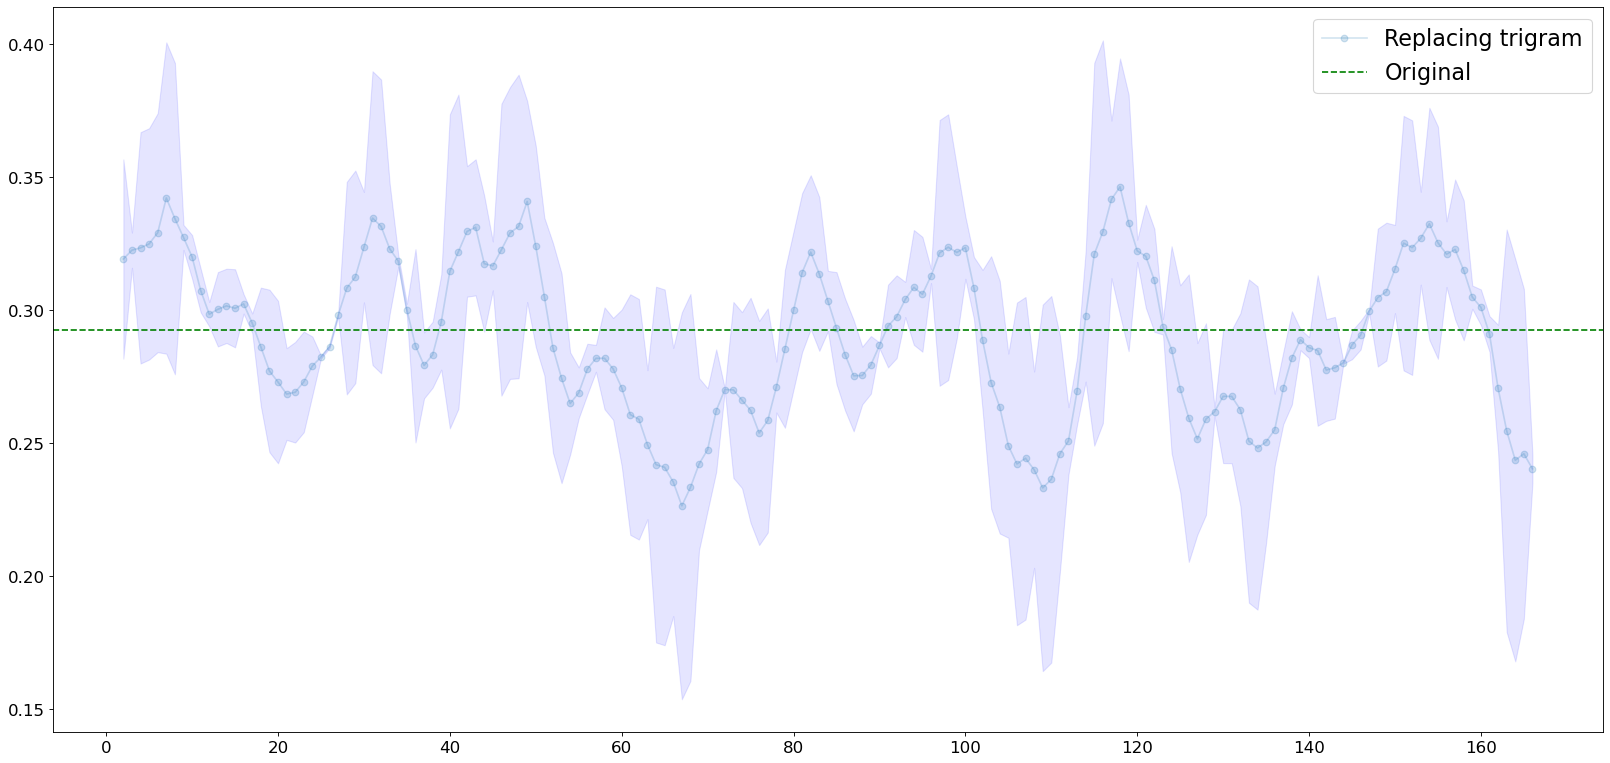

In [63]:
figure(figsize=(25, 12), dpi=80)
x = range(len(schmoo_df1_pred['Trigram_replaced_1'].tolist())-1)
window_size = 5
y = moving_avg(schmoo_df1_pred['avg'].tolist()[1:], window_size=window_size)
y_err = schmoo_df1_pred['avg_delta'].tolist()[1:]
ymax = [(y[j]+np.abs(y_err[j])) for j in x]
ymin = [(y[j]-np.abs(y_err[j])) for j in x]
plt.plot(x,y, '-o', alpha=0.2, label='Replacing trigram')
plt.fill_between(x, ymax, ymin, color='blue', alpha=0.1)
plt.axhline(y=schmoo_df1_pred['avg'].tolist()[0], color='g', linestyle='--', label='Original')
plt.xticks(np.arange(min(x), max(x)+1, 20),rotation = 0,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.legend(fontsize=20)
plt.show()

## FADD - CASP8

## Amino Acid Sequences

In [64]:
FADD = 'MDPFLVLLHSVSSSLSSSELTELKFLCLGRVGKRKLERVQSGLDLFSMLLEQNDLEPGHTELLRELLASLRRHDLLRRVDDFEAGAAAGAAPGEEDLCAAFNVICDNVGKDWRRLARQLKVSDTKIDSIEDRYPRNLTERVRESLRIWKNTEKENATVAHLVGALRSCQMNLVADLVQEVQQARDLQNRSGAMSPMSWNSDASTSEAS'

CASP8 = 'MDFSRNLYDIGEQLDSEDLASLKFLSLDYIPQRKQEPIKDALMLFQRLQEKRMLEESNLSFLKELLFRINRLDLLITYLNTRKEEMERELQTPGRAQISAYRVMLYQISEEVSRSELRSFKFLLQEEISKCKLDDDMNLLDIFIEMEKRVILGEGKLDILKRVCAQINKSLLKIINDYEEFSKERSSSLEGSPDEFSNGEELCGVMTISDSPREQDSESQTLDKVYQMKSKPRGYCLIINNHNFAKAREKVPKLHSIRDRNGTHLDAGALTTTFEELHFEIKPHDDCTVEQIYEILKIYQLMDHSNMDCFICCILSHGDKGIIYGTDGQEAPIYELTSQFTGLKCPSLAGKPKVFFIQACQGDNYQKGIPVETDSEEQPYLEMDLSSPQTRYIPDEADFLLGMATVNNCVSYRNPAEGTWYIQSLCQSLRERCPRGDDILTILTEVNYEVSNKDDKKNMGKQMPQPTFTLRKKLVFPSD'

In [65]:
protein_seq1 = FADD # Ablated
protein_seq2 = CASP8 # Fixed

t1_l = []
t2_l = []
residue_loc_1_l = []
residue_loc_2_l = []
p1_l = []
p2_l = []

for i in tqdm(range(0,len(protein_seq1)-2)):
    
    replaced_trigram1, protein_seq_replaced1 = replacer(protein_seq1, 'xxx', index=i, nofail=False)
    
    t1_l.append(replaced_trigram1)
    residue_loc_1_l.append(protein_seq1[i] + '-' + str(i) + '-' + protein_seq1[i+1] + '-' + str(i+1) + '-' + protein_seq1[i+2] + '-' + str(i+2))
    p1_l.append(protein_seq_replaced1)
    t2_l.append('None')
    residue_loc_2_l.append('None')
    p2_l.append(protein_seq2)

schmoo_df1 = pd.DataFrame()
schmoo_df1['Trigram_replaced_1'] = ['None'] + t1_l
schmoo_df1['Residue_locations_1'] = ['None'] + residue_loc_1_l
schmoo_df1['Modified_sequence_1'] = [protein_seq1] + p1_l
schmoo_df1['Trigram_replaced_2'] = ['None'] + t2_l
schmoo_df1['Residue_locations_2'] = ['None'] + residue_loc_2_l
schmoo_df1['Modified_sequence_2'] = [protein_seq2] + p2_l

100%|██████████| 206/206 [00:00<00:00, 383500.50it/s]


In [66]:
schmoo_df1_protvec, X = get_protvec(protvec_model,schmoo_df1)

100%|██████████| 207/207 [00:00<00:00, 81676.47it/s]


In [67]:
schmoo_df1_pred = get_compplete_pred(schmoo_df1,X)

7/7 [==============================] - 0s 2ms/step


In [68]:
l = schmoo_df1_pred['avg'].tolist()
print(min(l),max(l))

0.7731314897537231 0.8968133926391602


/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


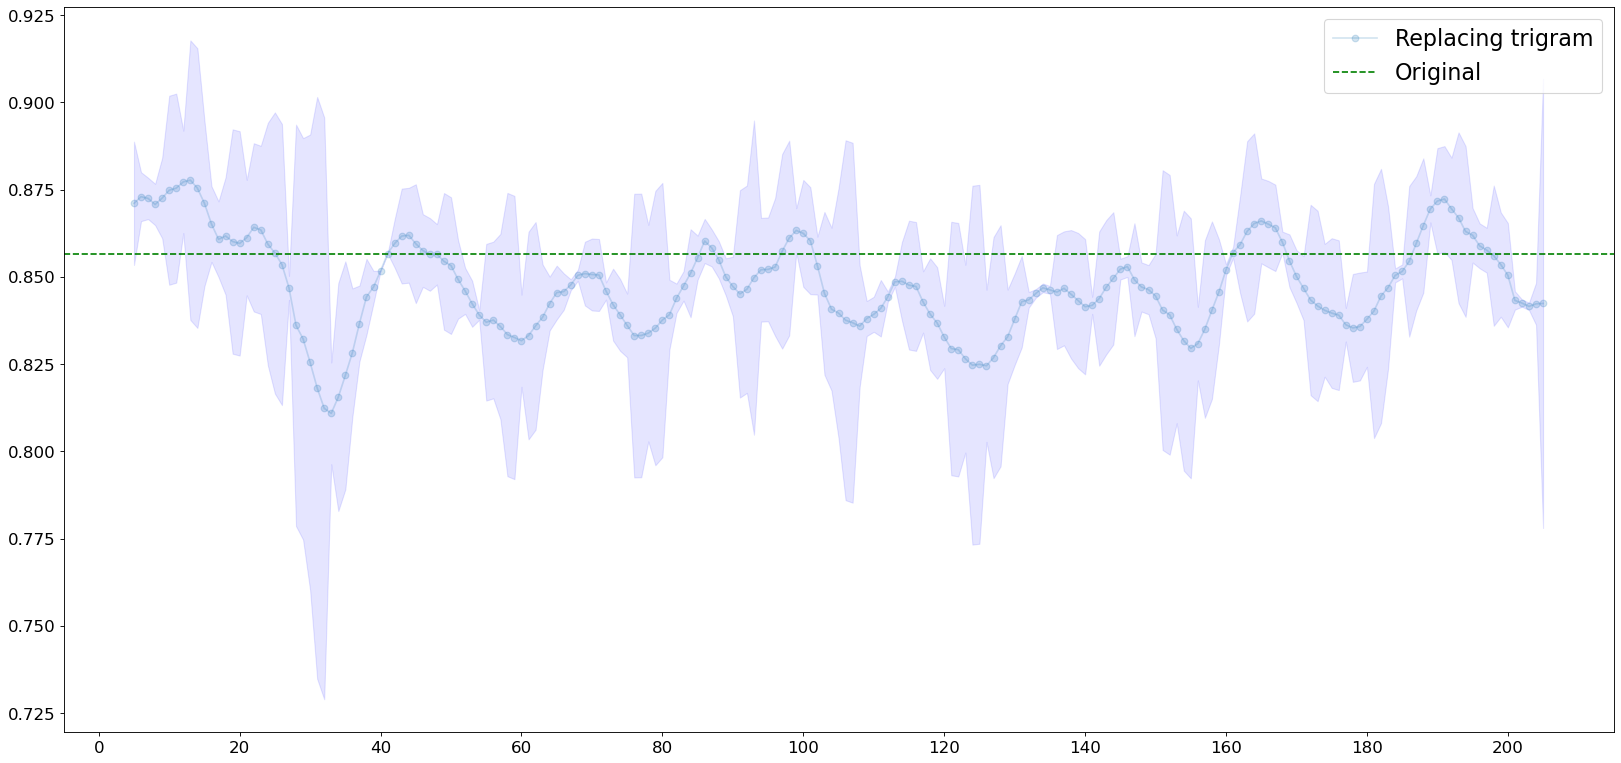

In [69]:
figure(figsize=(25, 12), dpi=80)
x = range(len(schmoo_df1_pred['Trigram_replaced_1'].tolist())-1)
window_size = 10
y = moving_avg(schmoo_df1_pred['avg'].tolist()[1:], window_size=window_size)
y_err = schmoo_df1_pred['avg_delta'].tolist()[1:]
ymax = [(y[j]+np.abs(y_err[j])) for j in x]
ymin = [(y[j]-np.abs(y_err[j])) for j in x]
plt.plot(x,y, '-o', alpha=0.2, label='Replacing trigram')
plt.fill_between(x, ymax, ymin, color='blue', alpha=0.1)
plt.axhline(y=schmoo_df1_pred['avg'].tolist()[0], color='g', linestyle='--', label='Original')
plt.xticks(np.arange(min(x), max(x)+1, 20),rotation = 0,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.legend(fontsize=20)
plt.show()

## CASP8 - FADD

## Amino Acid Sequences

In [70]:
FADD = 'MDPFLVLLHSVSSSLSSSELTELKFLCLGRVGKRKLERVQSGLDLFSMLLEQNDLEPGHTELLRELLASLRRHDLLRRVDDFEAGAAAGAAPGEEDLCAAFNVICDNVGKDWRRLARQLKVSDTKIDSIEDRYPRNLTERVRESLRIWKNTEKENATVAHLVGALRSCQMNLVADLVQEVQQARDLQNRSGAMSPMSWNSDASTSEAS'

CASP8 = 'MDFSRNLYDIGEQLDSEDLASLKFLSLDYIPQRKQEPIKDALMLFQRLQEKRMLEESNLSFLKELLFRINRLDLLITYLNTRKEEMERELQTPGRAQISAYRVMLYQISEEVSRSELRSFKFLLQEEISKCKLDDDMNLLDIFIEMEKRVILGEGKLDILKRVCAQINKSLLKIINDYEEFSKERSSSLEGSPDEFSNGEELCGVMTISDSPREQDSESQTLDKVYQMKSKPRGYCLIINNHNFAKAREKVPKLHSIRDRNGTHLDAGALTTTFEELHFEIKPHDDCTVEQIYEILKIYQLMDHSNMDCFICCILSHGDKGIIYGTDGQEAPIYELTSQFTGLKCPSLAGKPKVFFIQACQGDNYQKGIPVETDSEEQPYLEMDLSSPQTRYIPDEADFLLGMATVNNCVSYRNPAEGTWYIQSLCQSLRERCPRGDDILTILTEVNYEVSNKDDKKNMGKQMPQPTFTLRKKLVFPSD'

In [71]:
protein_seq1 = CASP8 # Ablated
protein_seq2 = FADD # Fixed

t1_l = []
t2_l = []
residue_loc_1_l = []
residue_loc_2_l = []
p1_l = []
p2_l = []

for i in tqdm(range(0,len(protein_seq1)-2)):
    
    replaced_trigram1, protein_seq_replaced1 = replacer(protein_seq1, 'xxx', index=i, nofail=False)
    
    t1_l.append(replaced_trigram1)
    residue_loc_1_l.append(protein_seq1[i] + '-' + str(i) + '-' + protein_seq1[i+1] + '-' + str(i+1) + '-' + protein_seq1[i+2] + '-' + str(i+2))
    p1_l.append(protein_seq_replaced1)
    t2_l.append('None')
    residue_loc_2_l.append('None')
    p2_l.append(protein_seq2)

schmoo_df1 = pd.DataFrame()
schmoo_df1['Trigram_replaced_1'] = ['None'] + t1_l
schmoo_df1['Residue_locations_1'] = ['None'] + residue_loc_1_l
schmoo_df1['Modified_sequence_1'] = [protein_seq1] + p1_l
schmoo_df1['Trigram_replaced_2'] = ['None'] + t2_l
schmoo_df1['Residue_locations_2'] = ['None'] + residue_loc_2_l
schmoo_df1['Modified_sequence_2'] = [protein_seq2] + p2_l

100%|██████████| 477/477 [00:00<00:00, 391599.73it/s]


In [72]:
schmoo_df1_protvec, X = get_protvec(protvec_model,schmoo_df1)

100%|██████████| 478/478 [00:00<00:00, 100803.32it/s]


In [73]:
schmoo_df1_pred = get_compplete_pred(schmoo_df1,X)

15/15 [==============================] - 0s 2ms/step


In [74]:
l = schmoo_df1_pred['avg'].tolist()
print(min(l),max(l))

0.7903534173965454 0.8864502906799316


/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


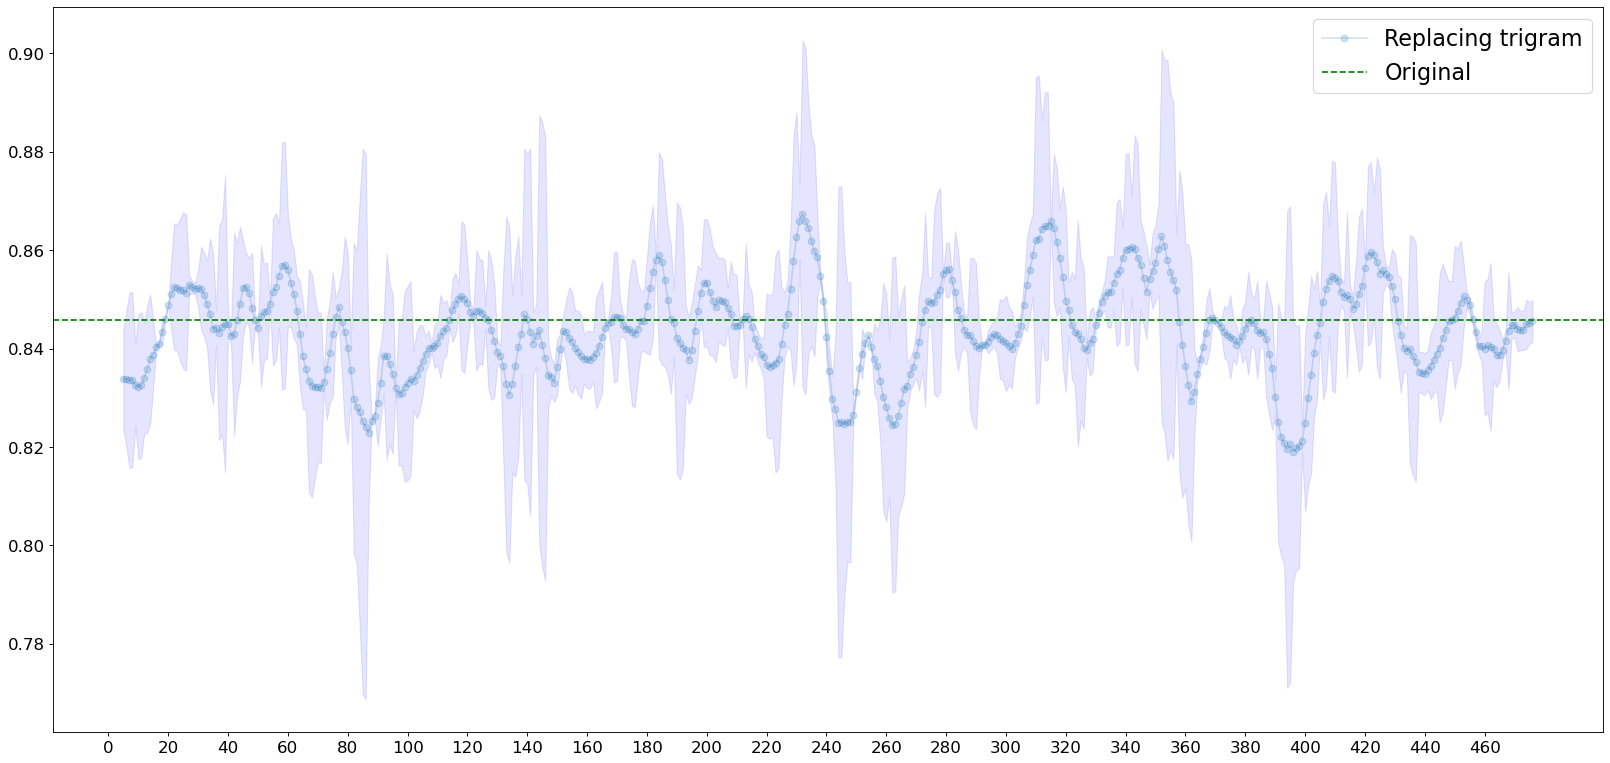

In [75]:
figure(figsize=(25, 12), dpi=80)
x = range(len(schmoo_df1_pred['Trigram_replaced_1'].tolist())-1)
window_size = 10
y = moving_avg(schmoo_df1_pred['avg'].tolist()[1:], window_size=window_size)
y_err = schmoo_df1_pred['avg_delta'].tolist()[1:]
ymax = [(y[j]+np.abs(y_err[j])) for j in x]
ymin = [(y[j]-np.abs(y_err[j])) for j in x]
plt.plot(x,y, '-o', alpha=0.2, label='Replacing trigram')
plt.fill_between(x, ymax, ymin, color='blue', alpha=0.1)
plt.axhline(y=schmoo_df1_pred['avg'].tolist()[0], color='g', linestyle='--', label='Original')
plt.xticks(np.arange(min(x), max(x)+1, 20),rotation = 0,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.legend(fontsize=20)
plt.show()

## CFH - C3

## Amino Acid Sequences

In [76]:
CFH = 'MRLLAKIICLMLWAICVAEDCNELPPRRNTEILTGSWSDQTYPEGTQAIYKCRPGYRSLGNVIMVCRKGEWVALNPLRKCQKRPCGHPGDTPFGTFTLTGGNVFEYGVKAVYTCNEGYQLLGEINYRECDTDGWTNDIPICEVVKCLPVTAPENGKIVSSAMEPDREYHFGQAVRFVCNSGYKIEGDEEMHCSDDGFWSKEKPKCVEISCKSPDVINGSPISQKIIYKENERFQYKCNMGYEYSERGDAVCTESGWRPLPSCEEKSCDNPYIPNGDYSPLRIKHRTGDEITYQCRNGFYPATRGNTAKCTSTGWIPAPRCTLKPCDYPDIKHGGLYHENMRRPYFPVAVGKYYSYYCDEHFETPSGSYWDHIHCTQDGWSPAVPCLRKCYFPYLENGYNQNYGRKFVQGKSIDVACHPGYALPKAQTTVTCMENGWSPTPRCIRVKTCSKSSIDIENGFISESQYTYALKEKAKYQCKLGYVTADGETSGSITCGKDGWSAQPTCIKSCDIPVFMNARTKNDFTWFKLNDTLDYECHDGYESNTGSTTGSIVCGYNGWSDLPICYERECELPKIDVHLVPDRKKDQYKVGEVLKFSCKPGFTIVGPNSVQCYHFGLSPDLPICKEQVQSCGPPPELLNGNVKEKTKEEYGHSEVVEYYCNPRFLMKGPNKIQCVDGEWTTLPVCIVEESTCGDIPELEHGWAQLSSPPYYYGDSVEFNCSESFTMIGHRSITCIHGVWTQLPQCVAIDKLKKCKSSNLIILEEHLKNKKEFDHNSNIRYRCRGKEGWIHTVCINGRWDPEVNCSMAQIQLCPPPPQIPNSHNMTTTLNYRDGEKVSVLCQENYLIQEGEEITCKDGRWQSIPLCVEKIPCSQPPQIEHGTINSSRSSQESYAHGTKLSYTCEGGFRISEENETTCYMGKWSSPPQCEGLPCKSPPEISHGVVAHMSDSYQYGEEVTYKCFEGFGIDGPAIAKCLGEKWSHPPSCIKTDCLSLPSFENAIPMGEKKDVYKAGEQVTYTCATYYKMDGASNVTCINSRWTGRPTCRDTSCVNPPTVQNAYIVSRQMSKYPSGERVRYQCRSPYEMFGDEEVMCLNGNWTEPPQCKDSTGKCGPPPPIDNGDITSFPLSVYAPASSVEYQCQNLYQLEGNKRITCRNGQWSEPPKCLHPCVISREIMENYNIALRWTAKQKLYSRTGESVEFVCKRGYRLSSRSHTLRTTCWDGKLEYPTCAKR'

C3 = 'MGPTSGPSLLLLLLTHLPLALGSPMYSIITPNILRLESEETMVLEAHDAQGDVPVTVTVHDFPGKKLVLSSEKTVLTPATNHMGNVTFTIPANREFKSEKGRNKFVTVQATFGTQVVEKVVLVSLQSGYLFIQTDKTIYTPGSTVLYRIFTVNHKLLPVGRTVMVNIENPEGIPVKQDSLSSQNQLGVLPLSWDIPELVNMGQWKIRAYYENSPQQVFSTEFEVKEYVLPSFEVIVEPTEKFYYIYNEKGLEVTITARFLYGKKVEGTAFVIFGIQDGEQRISLPESLKRIPIEDGSGEVVLSRKVLLDGVQNPRAEDLVGKSLYVSATVILHSGSDMVQAERSGIPIVTSPYQIHFTKTPKYFKPGMPFDLMVFVTNPDGSPAYRVPVAVQGEDTVQSLTQGDGVAKLSINTHPSQKPLSITVRTKKQELSEAEQATRTMQALPYSTVGNSNNYLHLSVLRTELRPGETLNVNFLLRMDRAHEAKIRYYTYLIMNKGRLLKAGRQVREPGQDLVVLPLSITTDFIPSFRLVAYYTLIGASGQREVVADSVWVDVKDSCVGSLVVKSGQSEDRQPVPGQQMTLKIEGDHGARVVLVAVDKGVFVLNKKNKLTQSKIWDVVEKADIGCTPGSGKDYAGVFSDAGLTFTSSSGQQTAQRAELQCPQPAARRRRSVQLTEKRMDKVGKYPKELRKCCEDGMRENPMRFSCQRRTRFISLGEACKKVFLDCCNYITELRRQHARASHLGLARSNLDEDIIAEENIVSRSEFPESWLWNVEDLKEPPKNGISTKLMNIFLKDSITTWEILAVSMSDKKGICVADPFEVTVMQDFFIDLRLPYSVVRNEQVEIRAVLYNYRQNQELKVRVELLHNPAFCSLATTKRRHQQTVTIPPKSSLSVPYVIVPLKTGLQEVEVKAAVYHHFISDGVRKSLKVVPEGIRMNKTVAVRTLDPERLGREGVQKEDIPPADLSDQVPDTESETRILLQGTPVAQMTEDAVDAERLKHLIVTPSGCGEQNMIGMTPTVIAVHYLDETEQWEKFGLEKRQGALELIKKGYTQQLAFRQPSSAFAAFVKRAPSTWLTAYVVKVFSLAVNLIAIDSQVLCGAVKWLILEKQKPDGVFQEDAPVIHQEMIGGLRNNNEKDMALTAFVLISLQEAKDICEEQVNSLPGSITKAGDFLEANYMNLQRSYTVAIAGYALAQMGRLKGPLLNKFLTTAKDKNRWEDPGKQLYNVEATSYALLALLQLKDFDFVPPVVRWLNEQRYYGGGYGSTQATFMVFQALAQYQKDAPDHQELNLDVSLQLPSRSSKITHRIHWESASLLRSEETKENEGFTVTAEGKGQGTLSVVTMYHAKAKDQLTCNKFDLKVTIKPAPETEKRPQDAKNTMILEICTRYRGDQDATMSILDISMMTGFAPDTDDLKQLANGVDRYISKYELDKAFSDRNTLIIYLDKVSHSEDDCLAFKVHQYFNVELIQPGAVKVYAYYNLEESCTRFYHPEKEDGKLNKLCRDELCRCAEENCFIQKSDDKVTLEERLDKACEPGVDYVYKTRLVKVQLSNDFDEYIMAIEQTIKSGSDEVQVGQQRTFISPIKCREALKLEEKKHYLMWGLSSDFWGEKPNLSYIIGKDTWVEHWPEEDECQDEENQKQCQDLGAFTESMVVFGCPN'

In [77]:
protein_seq1 = CFH # Ablated
protein_seq2 = C3 # Fixed

t1_l = []
t2_l = []
residue_loc_1_l = []
residue_loc_2_l = []
p1_l = []
p2_l = []

for i in tqdm(range(0,len(protein_seq1)-2)):
    
    replaced_trigram1, protein_seq_replaced1 = replacer(protein_seq1, 'xxx', index=i, nofail=False)
    
    t1_l.append(replaced_trigram1)
    residue_loc_1_l.append(protein_seq1[i] + '-' + str(i) + '-' + protein_seq1[i+1] + '-' + str(i+1) + '-' + protein_seq1[i+2] + '-' + str(i+2))
    p1_l.append(protein_seq_replaced1)
    t2_l.append('None')
    residue_loc_2_l.append('None')
    p2_l.append(protein_seq2)

schmoo_df1 = pd.DataFrame()
schmoo_df1['Trigram_replaced_1'] = ['None'] + t1_l
schmoo_df1['Residue_locations_1'] = ['None'] + residue_loc_1_l
schmoo_df1['Modified_sequence_1'] = [protein_seq1] + p1_l
schmoo_df1['Trigram_replaced_2'] = ['None'] + t2_l
schmoo_df1['Residue_locations_2'] = ['None'] + residue_loc_2_l
schmoo_df1['Modified_sequence_2'] = [protein_seq2] + p2_l

100%|██████████| 1229/1229 [00:00<00:00, 402907.58it/s]


In [78]:
schmoo_df1_protvec, X = get_protvec(protvec_model,schmoo_df1)

100%|██████████| 1230/1230 [00:00<00:00, 88612.06it/s]


In [79]:
schmoo_df1_pred = get_compplete_pred(schmoo_df1,X)

39/39 [==============================] - 0s 2ms/step


In [80]:
l = schmoo_df1_pred['avg'].tolist()
print(min(l),max(l))

0.8796787261962891 0.9422411918640137


/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


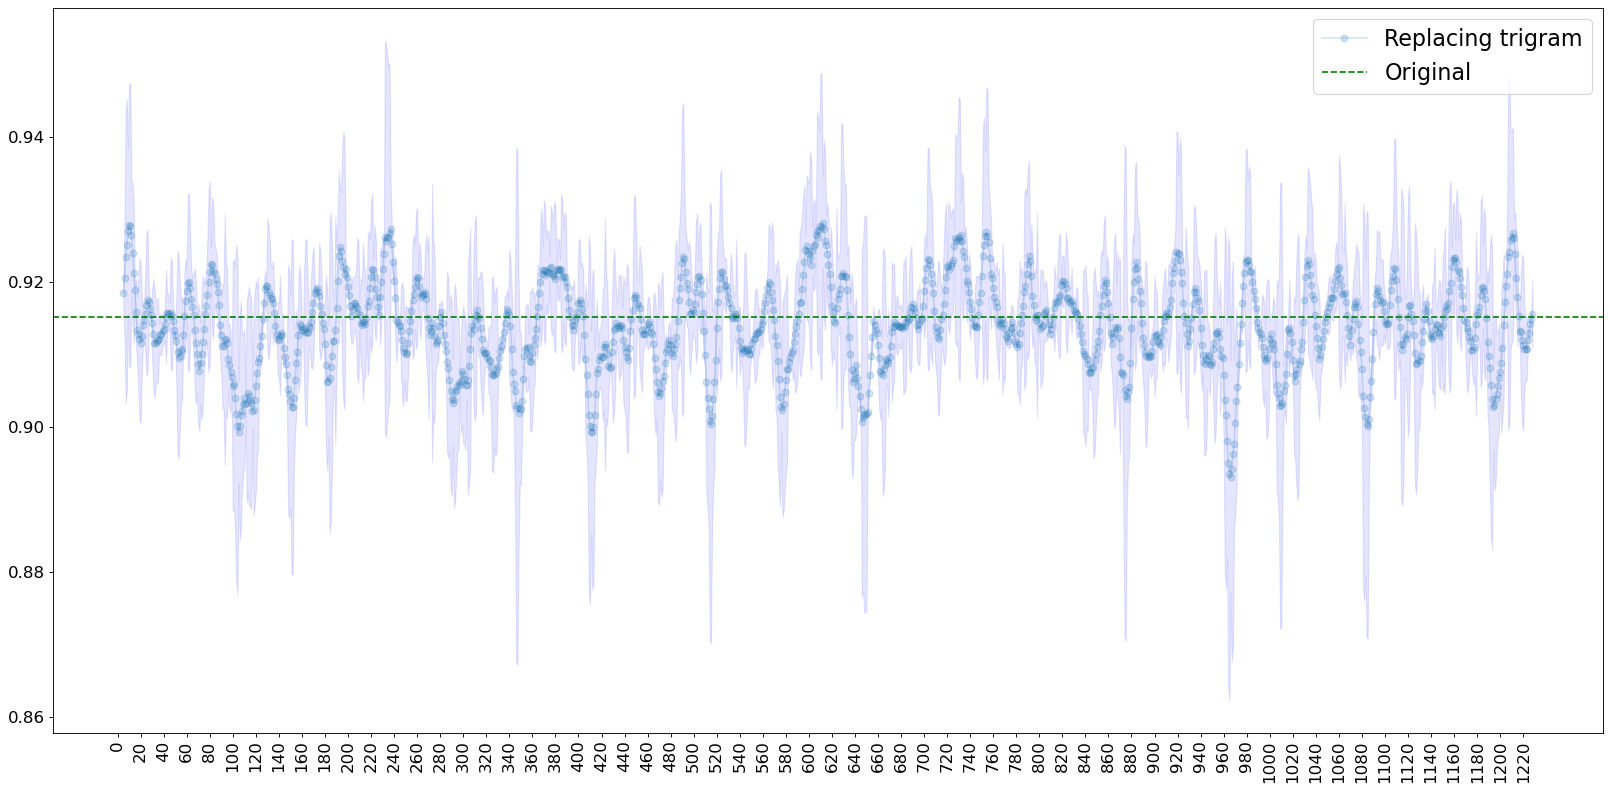

In [81]:
figure(figsize=(25, 12), dpi=80)
x = range(len(schmoo_df1_pred['Trigram_replaced_1'].tolist())-1)
window_size = 10
y = moving_avg(schmoo_df1_pred['avg'].tolist()[1:], window_size=window_size)
y_err = schmoo_df1_pred['avg_delta'].tolist()[1:]
ymax = [(y[j]+np.abs(y_err[j])) for j in x]
ymin = [(y[j]-np.abs(y_err[j])) for j in x]
plt.plot(x,y, '-o', alpha=0.2, label='Replacing trigram')
plt.fill_between(x, ymax, ymin, color='blue', alpha=0.1)
plt.axhline(y=schmoo_df1_pred['avg'].tolist()[0], color='g', linestyle='--', label='Original')
plt.xticks(np.arange(min(x), max(x)+1, 20),rotation = 90,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.legend(fontsize=20)
plt.show()

## C3 - CFH

## Amino Acid Sequences

In [82]:
CFH = 'MRLLAKIICLMLWAICVAEDCNELPPRRNTEILTGSWSDQTYPEGTQAIYKCRPGYRSLGNVIMVCRKGEWVALNPLRKCQKRPCGHPGDTPFGTFTLTGGNVFEYGVKAVYTCNEGYQLLGEINYRECDTDGWTNDIPICEVVKCLPVTAPENGKIVSSAMEPDREYHFGQAVRFVCNSGYKIEGDEEMHCSDDGFWSKEKPKCVEISCKSPDVINGSPISQKIIYKENERFQYKCNMGYEYSERGDAVCTESGWRPLPSCEEKSCDNPYIPNGDYSPLRIKHRTGDEITYQCRNGFYPATRGNTAKCTSTGWIPAPRCTLKPCDYPDIKHGGLYHENMRRPYFPVAVGKYYSYYCDEHFETPSGSYWDHIHCTQDGWSPAVPCLRKCYFPYLENGYNQNYGRKFVQGKSIDVACHPGYALPKAQTTVTCMENGWSPTPRCIRVKTCSKSSIDIENGFISESQYTYALKEKAKYQCKLGYVTADGETSGSITCGKDGWSAQPTCIKSCDIPVFMNARTKNDFTWFKLNDTLDYECHDGYESNTGSTTGSIVCGYNGWSDLPICYERECELPKIDVHLVPDRKKDQYKVGEVLKFSCKPGFTIVGPNSVQCYHFGLSPDLPICKEQVQSCGPPPELLNGNVKEKTKEEYGHSEVVEYYCNPRFLMKGPNKIQCVDGEWTTLPVCIVEESTCGDIPELEHGWAQLSSPPYYYGDSVEFNCSESFTMIGHRSITCIHGVWTQLPQCVAIDKLKKCKSSNLIILEEHLKNKKEFDHNSNIRYRCRGKEGWIHTVCINGRWDPEVNCSMAQIQLCPPPPQIPNSHNMTTTLNYRDGEKVSVLCQENYLIQEGEEITCKDGRWQSIPLCVEKIPCSQPPQIEHGTINSSRSSQESYAHGTKLSYTCEGGFRISEENETTCYMGKWSSPPQCEGLPCKSPPEISHGVVAHMSDSYQYGEEVTYKCFEGFGIDGPAIAKCLGEKWSHPPSCIKTDCLSLPSFENAIPMGEKKDVYKAGEQVTYTCATYYKMDGASNVTCINSRWTGRPTCRDTSCVNPPTVQNAYIVSRQMSKYPSGERVRYQCRSPYEMFGDEEVMCLNGNWTEPPQCKDSTGKCGPPPPIDNGDITSFPLSVYAPASSVEYQCQNLYQLEGNKRITCRNGQWSEPPKCLHPCVISREIMENYNIALRWTAKQKLYSRTGESVEFVCKRGYRLSSRSHTLRTTCWDGKLEYPTCAKR'

C3 = 'MGPTSGPSLLLLLLTHLPLALGSPMYSIITPNILRLESEETMVLEAHDAQGDVPVTVTVHDFPGKKLVLSSEKTVLTPATNHMGNVTFTIPANREFKSEKGRNKFVTVQATFGTQVVEKVVLVSLQSGYLFIQTDKTIYTPGSTVLYRIFTVNHKLLPVGRTVMVNIENPEGIPVKQDSLSSQNQLGVLPLSWDIPELVNMGQWKIRAYYENSPQQVFSTEFEVKEYVLPSFEVIVEPTEKFYYIYNEKGLEVTITARFLYGKKVEGTAFVIFGIQDGEQRISLPESLKRIPIEDGSGEVVLSRKVLLDGVQNPRAEDLVGKSLYVSATVILHSGSDMVQAERSGIPIVTSPYQIHFTKTPKYFKPGMPFDLMVFVTNPDGSPAYRVPVAVQGEDTVQSLTQGDGVAKLSINTHPSQKPLSITVRTKKQELSEAEQATRTMQALPYSTVGNSNNYLHLSVLRTELRPGETLNVNFLLRMDRAHEAKIRYYTYLIMNKGRLLKAGRQVREPGQDLVVLPLSITTDFIPSFRLVAYYTLIGASGQREVVADSVWVDVKDSCVGSLVVKSGQSEDRQPVPGQQMTLKIEGDHGARVVLVAVDKGVFVLNKKNKLTQSKIWDVVEKADIGCTPGSGKDYAGVFSDAGLTFTSSSGQQTAQRAELQCPQPAARRRRSVQLTEKRMDKVGKYPKELRKCCEDGMRENPMRFSCQRRTRFISLGEACKKVFLDCCNYITELRRQHARASHLGLARSNLDEDIIAEENIVSRSEFPESWLWNVEDLKEPPKNGISTKLMNIFLKDSITTWEILAVSMSDKKGICVADPFEVTVMQDFFIDLRLPYSVVRNEQVEIRAVLYNYRQNQELKVRVELLHNPAFCSLATTKRRHQQTVTIPPKSSLSVPYVIVPLKTGLQEVEVKAAVYHHFISDGVRKSLKVVPEGIRMNKTVAVRTLDPERLGREGVQKEDIPPADLSDQVPDTESETRILLQGTPVAQMTEDAVDAERLKHLIVTPSGCGEQNMIGMTPTVIAVHYLDETEQWEKFGLEKRQGALELIKKGYTQQLAFRQPSSAFAAFVKRAPSTWLTAYVVKVFSLAVNLIAIDSQVLCGAVKWLILEKQKPDGVFQEDAPVIHQEMIGGLRNNNEKDMALTAFVLISLQEAKDICEEQVNSLPGSITKAGDFLEANYMNLQRSYTVAIAGYALAQMGRLKGPLLNKFLTTAKDKNRWEDPGKQLYNVEATSYALLALLQLKDFDFVPPVVRWLNEQRYYGGGYGSTQATFMVFQALAQYQKDAPDHQELNLDVSLQLPSRSSKITHRIHWESASLLRSEETKENEGFTVTAEGKGQGTLSVVTMYHAKAKDQLTCNKFDLKVTIKPAPETEKRPQDAKNTMILEICTRYRGDQDATMSILDISMMTGFAPDTDDLKQLANGVDRYISKYELDKAFSDRNTLIIYLDKVSHSEDDCLAFKVHQYFNVELIQPGAVKVYAYYNLEESCTRFYHPEKEDGKLNKLCRDELCRCAEENCFIQKSDDKVTLEERLDKACEPGVDYVYKTRLVKVQLSNDFDEYIMAIEQTIKSGSDEVQVGQQRTFISPIKCREALKLEEKKHYLMWGLSSDFWGEKPNLSYIIGKDTWVEHWPEEDECQDEENQKQCQDLGAFTESMVVFGCPN'

In [83]:
protein_seq1 = C3 # Ablated
protein_seq2 = CFH # Fixed

t1_l = []
t2_l = []
residue_loc_1_l = []
residue_loc_2_l = []
p1_l = []
p2_l = []

for i in tqdm(range(0,len(protein_seq1)-2)):
    
    replaced_trigram1, protein_seq_replaced1 = replacer(protein_seq1, 'xxx', index=i, nofail=False)
    
    t1_l.append(replaced_trigram1)
    residue_loc_1_l.append(protein_seq1[i] + '-' + str(i) + '-' + protein_seq1[i+1] + '-' + str(i+1) + '-' + protein_seq1[i+2] + '-' + str(i+2))
    p1_l.append(protein_seq_replaced1)
    t2_l.append('None')
    residue_loc_2_l.append('None')
    p2_l.append(protein_seq2)

schmoo_df1 = pd.DataFrame()
schmoo_df1['Trigram_replaced_1'] = ['None'] + t1_l
schmoo_df1['Residue_locations_1'] = ['None'] + residue_loc_1_l
schmoo_df1['Modified_sequence_1'] = [protein_seq1] + p1_l
schmoo_df1['Trigram_replaced_2'] = ['None'] + t2_l
schmoo_df1['Residue_locations_2'] = ['None'] + residue_loc_2_l
schmoo_df1['Modified_sequence_2'] = [protein_seq2] + p2_l

100%|██████████| 1661/1661 [00:00<00:00, 400065.40it/s]


In [84]:
schmoo_df1_protvec, X = get_protvec(protvec_model,schmoo_df1)

100%|██████████| 1662/1662 [00:00<00:00, 101362.96it/s]


In [85]:
schmoo_df1_pred = get_compplete_pred(schmoo_df1,X)

52/52 [==============================] - 0s 2ms/step


In [86]:
l = schmoo_df1_pred['avg'].tolist()
print(min(l),max(l))

0.91941899061203 0.9522393345832825


/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/scp/.dev/tf/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


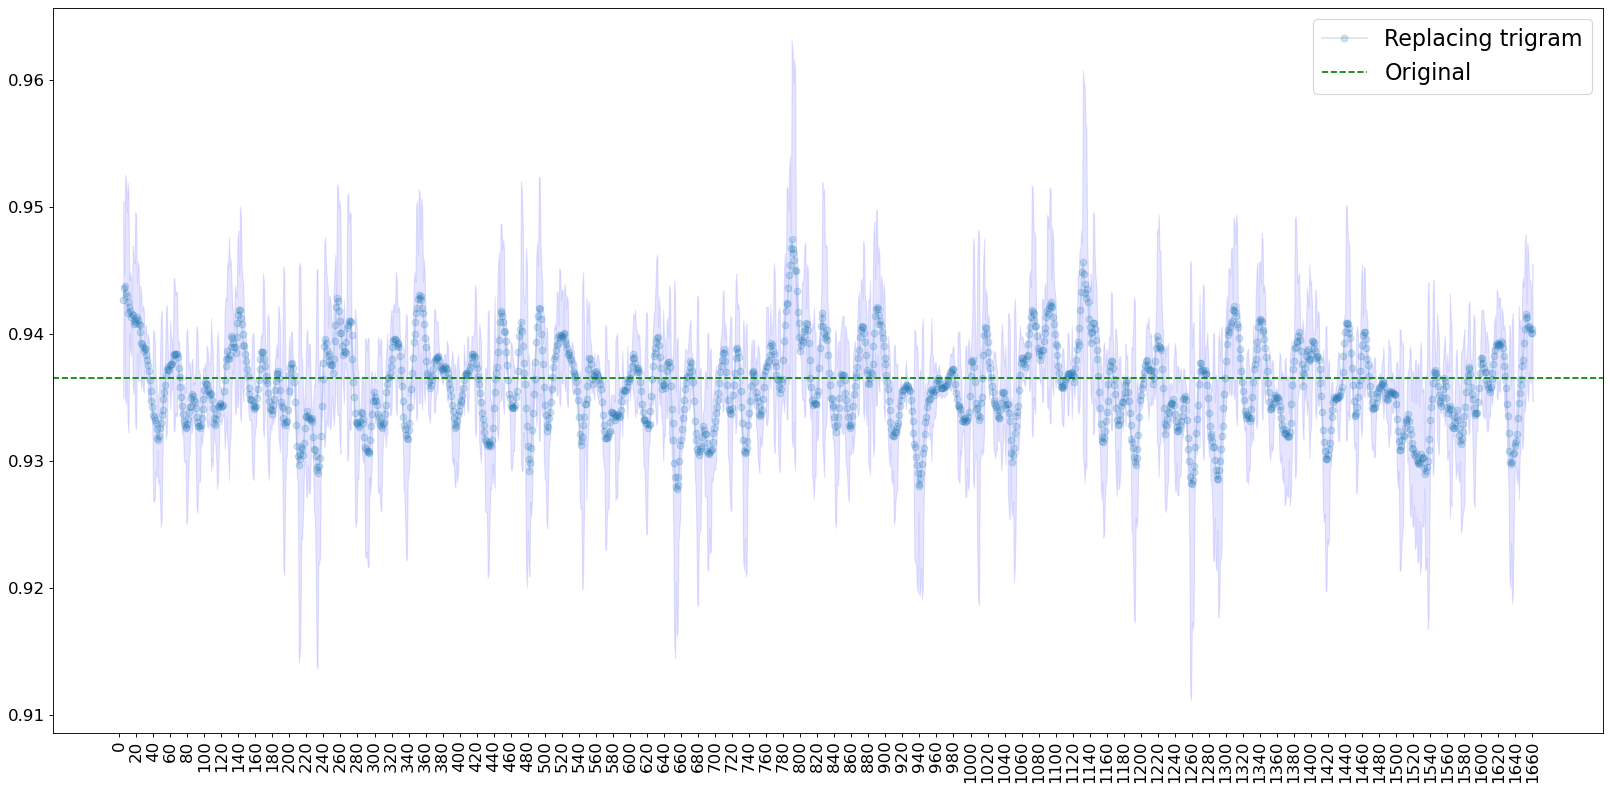

In [87]:
figure(figsize=(25, 12), dpi=80)
x = range(len(schmoo_df1_pred['Trigram_replaced_1'].tolist())-1)
window_size = 10
y = moving_avg(schmoo_df1_pred['avg'].tolist()[1:], window_size=window_size)
y_err = schmoo_df1_pred['avg_delta'].tolist()[1:]
ymax = [(y[j]+np.abs(y_err[j])) for j in x]
ymin = [(y[j]-np.abs(y_err[j])) for j in x]
plt.plot(x,y, '-o', alpha=0.2, label='Replacing trigram')
plt.fill_between(x, ymax, ymin, color='blue', alpha=0.1)
plt.axhline(y=schmoo_df1_pred['avg'].tolist()[0], color='g', linestyle='--', label='Original')
plt.xticks(np.arange(min(x), max(x)+1, 20),rotation = 90,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.legend(fontsize=20)
plt.show()